# Quantitative Portfolio Optimization
This project systematically constructs and evaluates two quantitatively optimized portfolios using 5 years of market data (2020–2025). The implementation focuses on:

- High-risk portfolio: Tech/growth stocks (NVDA-heavy allocation).

- Low-risk portfolio: Defensive equities (KO-dominated allocation).

Validated through rigorous backtesting and stress scenarios.

## Table of Contents
- Data Ingestion and Preprocessing.
- Market Regime Detection.
- Machine Learning Signal Generation.
- Portfolio Optimization.
- Backtesting Engine.
- Advanced Risk Metrics.
- Volatility Forecast.
- Factor Analysis.
- Correlation Analysis.
- Auto-Hedge Engine.
- Stress Testing.
- Final Portfolio Construction.
- Conclusion

## Initial Setup and Imports

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import datetime as dt
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import norm, skew, kurtosis
from matplotlib.ticker import PercentFormatter

warnings.filterwarnings("ignore")
plt.style.use('seaborn')
sns.set_palette("deep")
pd.options.display.float_format = '{:.4f}'.format

np.random.seed(42)

## 1. Data Ingestion and Preprocessing

[*********************100%***********************]  7 of 7 completed



Data Summary:
Date Range: 2020-06-24 to 2025-06-20
Missing Values:
Ticker
AAPL    0
ARKK    0
KO      0
NVDA    0
PG      0
SPCE    0
TSLA    0
dtype: int64

First 5 Rows:
Ticker        AAPL    ARKK      KO   NVDA       PG     SPCE    TSLA
Date                                                               
2020-06-24 87.5008 67.0907 38.3672 9.2052 102.9311 310.0000 64.0567
2020-06-25 88.6624 68.3299 38.6078 9.4588 104.2308 305.0000 65.7320
2020-06-26 85.9382 66.7712 37.4391 9.1249 101.8790 311.0000 63.9827
2020-06-29 87.9188 67.1488 38.1180 9.1698 104.0275 308.4000 67.2900
2020-06-30 88.6527 69.0366 38.3930 9.4665 105.7161 326.8000 71.9873


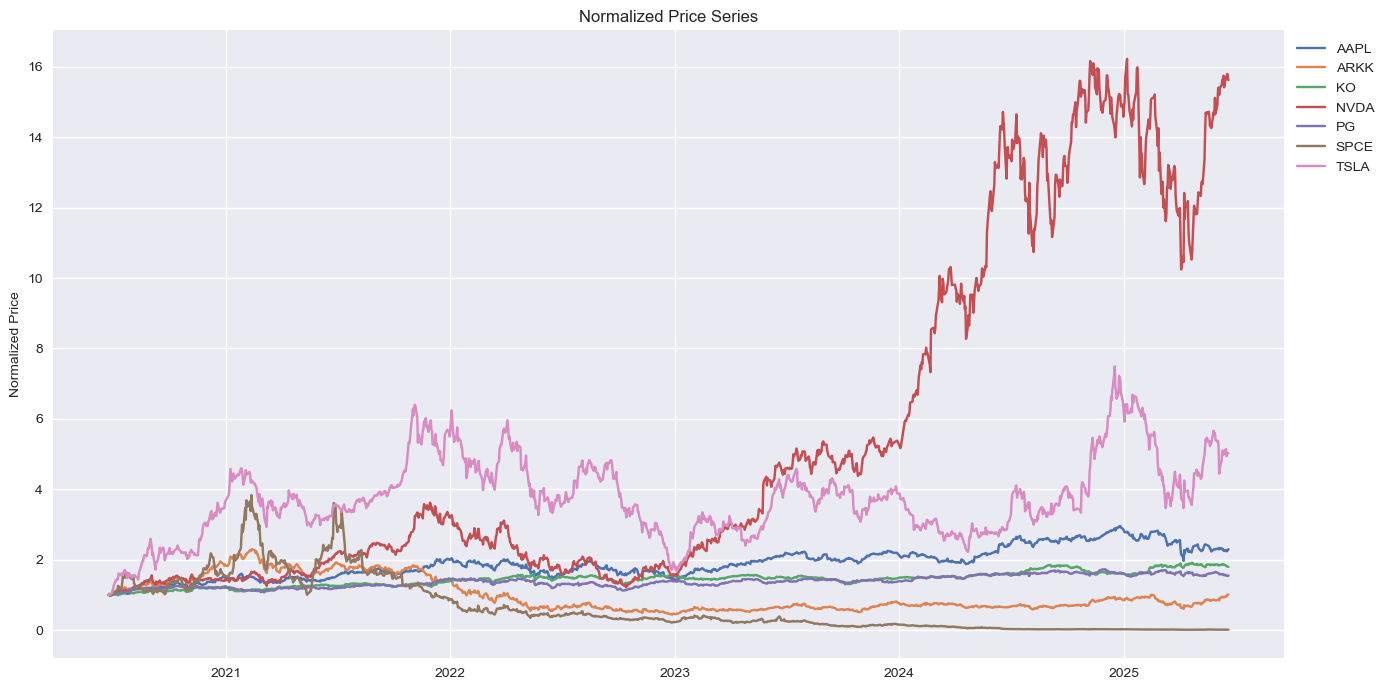

In [31]:
def get_ticker_data(tickers, start_date, end_date):
    """Fetch adjusted close prices from Yahoo Finance"""
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return data.sort_index()

# Define portfolio constituents
high_risk_tickers = ['TSLA', 'ARKK', 'SPCE', 'NVDA']
low_risk_tickers = ['AAPL', 'KO', 'PG']
all_tickers = high_risk_tickers + low_risk_tickers

end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(days=5*365)

data = get_ticker_data(all_tickers, start_date, end_date)

# Calculate log returns
returns = np.log(data / data.shift(1)).dropna()

print("\nData Summary:")
print(f"Date Range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Missing Values:\n{data.isnull().sum()}")
print("\nFirst 5 Rows:")
print(data.head())

plt.figure(figsize=(14, 7))
for ticker in data.columns:
    plt.plot(data.index, data[ticker]/data[ticker].iloc[0], label=ticker)
plt.title("Normalized Price Series")
plt.ylabel("Normalized Price")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Market Regime Detection

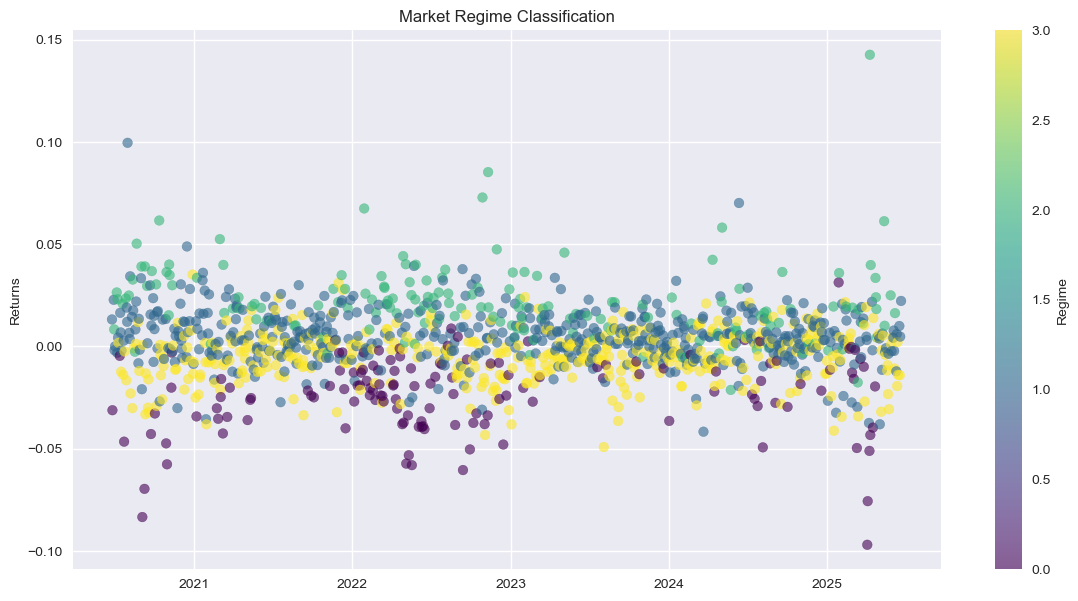

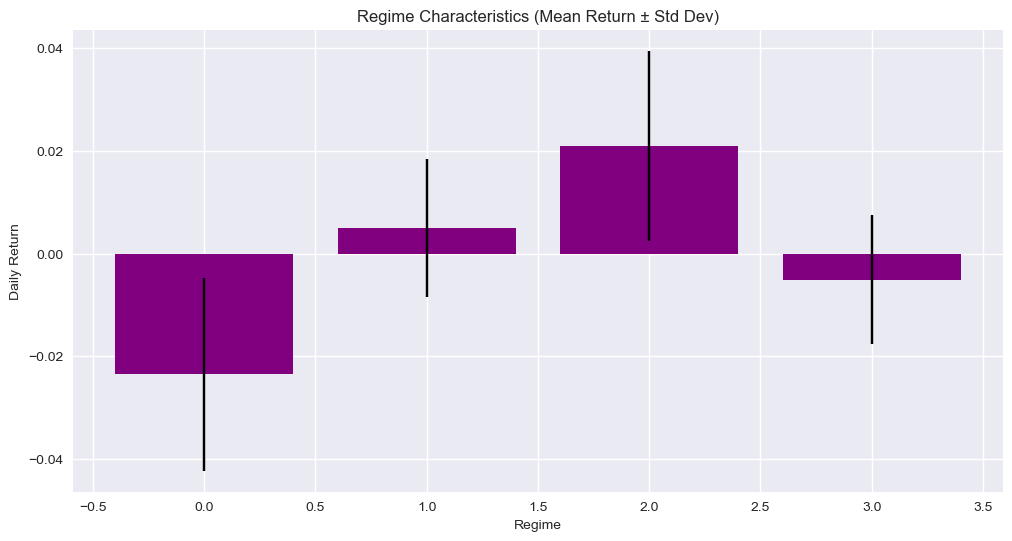

In [32]:
def detect_market_regimes(returns, n_clusters=4, plot=True):
    """Detect market regimes using PCA and K-Means clustering"""
    
    # Reduce dimensionality with PCA
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(returns)
    
    # Cluster reduced data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    regimes = kmeans.fit_predict(reduced_data)
    
    if plot:
        # Plot regime classification
        plt.figure(figsize=(14, 7))
        scatter = plt.scatter(returns.index, returns.iloc[:, 0], 
                             c=regimes, cmap='viridis', alpha=0.6)
        plt.title("Market Regime Classification")
        plt.ylabel("Returns")
        plt.colorbar(scatter, label='Regime')
        plt.grid(True)
        plt.show()
        
        # Plot regime characteristics
        regime_stats = returns.copy()
        regime_stats['Regime'] = regimes
        stats = regime_stats.groupby('Regime').agg(['mean', 'std'])
        
        plt.figure(figsize=(12, 6))
        plt.bar(stats.index, stats.iloc[:, 0], yerr=stats.iloc[:, 1], 
               capsize=5, color='purple')
        plt.title("Regime Characteristics (Mean Return ± Std Dev)")
        plt.xlabel("Regime")
        plt.ylabel("Daily Return")
        plt.grid(True)
        plt.show()
    
    return regimes

# Apply regime detection
regimes = detect_market_regimes(returns.drop(columns=returns.columns[-3:]))  
returns['Regime'] = regimes

## 3. Machine Learning Signal Generation

Features shape: (1250, 8)
Label distribution:
TSLA
1    628
0    622
Name: count, dtype: int64


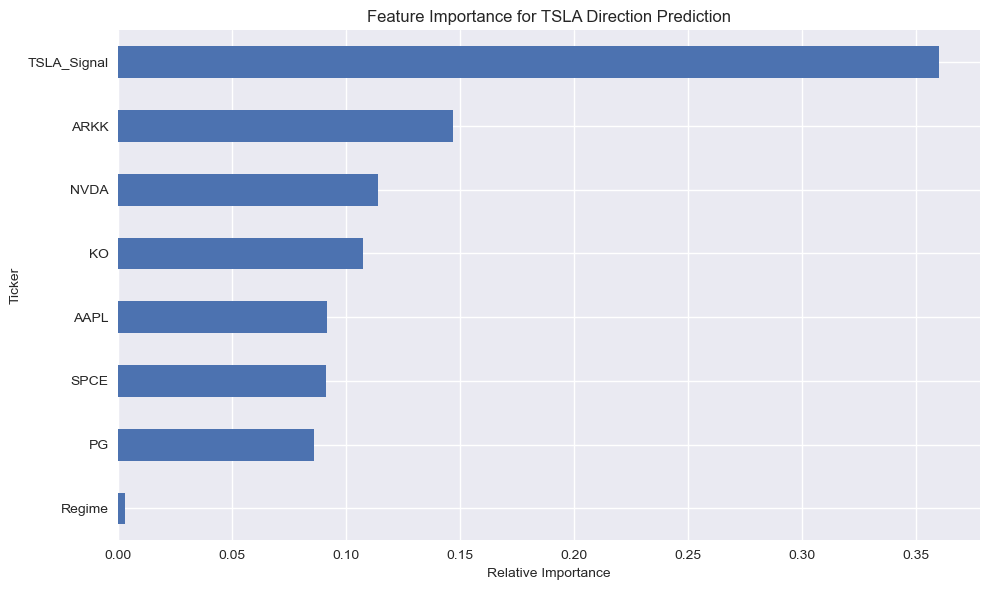

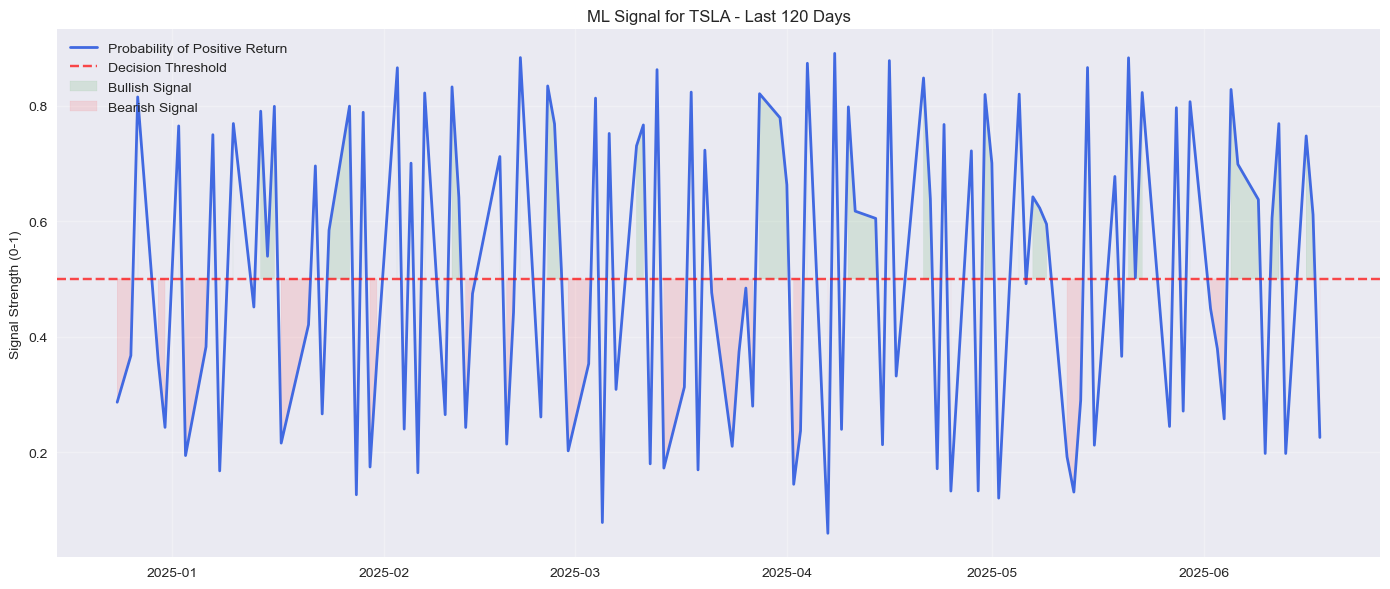


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       622
           1       0.91      0.88      0.89       628

    accuracy                           0.90      1250
   macro avg       0.90      0.90      0.90      1250
weighted avg       0.90      0.90      0.90      1250



In [36]:
def generate_ml_signals(returns, target_ticker='TSLA', lookahead=1, plot_days=100):
    """Generate machine learning trading signals with visualizations"""
    
    returns = returns.copy()
    
    features = returns.drop(columns=[target_ticker], errors='ignore')
    
    features = features.select_dtypes(include=[np.number])
    
    features = features.shift(lookahead).dropna()
    
    # Create binary labels (1 if price goes up, 0 otherwise)
    labels = (returns[target_ticker] > returns[target_ticker].shift(1)).shift(-lookahead)
    labels = labels.dropna().astype(int) 
    
    common_idx = features.index.intersection(labels.index)
    features = features.loc[common_idx]
    labels = labels.loc[common_idx]
    
    print(f"Features shape: {features.shape}")
    print(f"Label distribution:\n{labels.value_counts()}")
    
    clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.02,
                                   max_depth=5, random_state=42)
    clf.fit(features, labels)
    
    # Generate predictions
    pred_proba = clf.predict_proba(features)[:, 1]  # Probability of positive return
    
    plt.figure(figsize=(10, 6))
    feat_importance = pd.Series(clf.feature_importances_, index=features.columns)
    feat_importance.sort_values().plot(kind='barh')
    plt.title(f'Feature Importance for {target_ticker} Direction Prediction')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 6))
    
    plot_start = max(0, len(pred_proba)-plot_days)
    signal_dates = features.index[plot_start:]
    signal_values = pred_proba[plot_start:]
    
    plt.plot(signal_dates, signal_values, 
             label='Probability of Positive Return', 
             color='royalblue', 
             linewidth=2)
    
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Decision Threshold')
    
    plt.fill_between(signal_dates, signal_values, 0.5, 
                    where=(signal_values >= 0.5),
                    color='green', alpha=0.1, label='Bullish Signal')
    plt.fill_between(signal_dates, signal_values, 0.5, 
                    where=(signal_values < 0.5),
                    color='red', alpha=0.1, label='Bearish Signal')
    
    plt.title(f'ML Signal for {target_ticker} - Last {plot_days} Days')
    plt.ylabel('Signal Strength (0-1)')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(labels, clf.predict(features)))
    
    return pred_proba, features.index

try:
    tsla_signal, signal_index = generate_ml_signals(returns, plot_days=120)
    returns.loc[signal_index, 'TSLA_Signal'] = tsla_signal
except Exception as e:
    print(f"Error generating signals: {e}")
    print("Available columns:", returns.columns.tolist())

## 4. Portfolio Optimization


High Risk Portfolio Weights:
TSLA   0.0014
ARKK   0.0000
SPCE   0.0000
NVDA   0.5697
Name: Weight, dtype: float64

Low Risk Portfolio Weights:
AAPL   0.2460
KO     0.6220
PG     0.0699
Name: Weight, dtype: float64


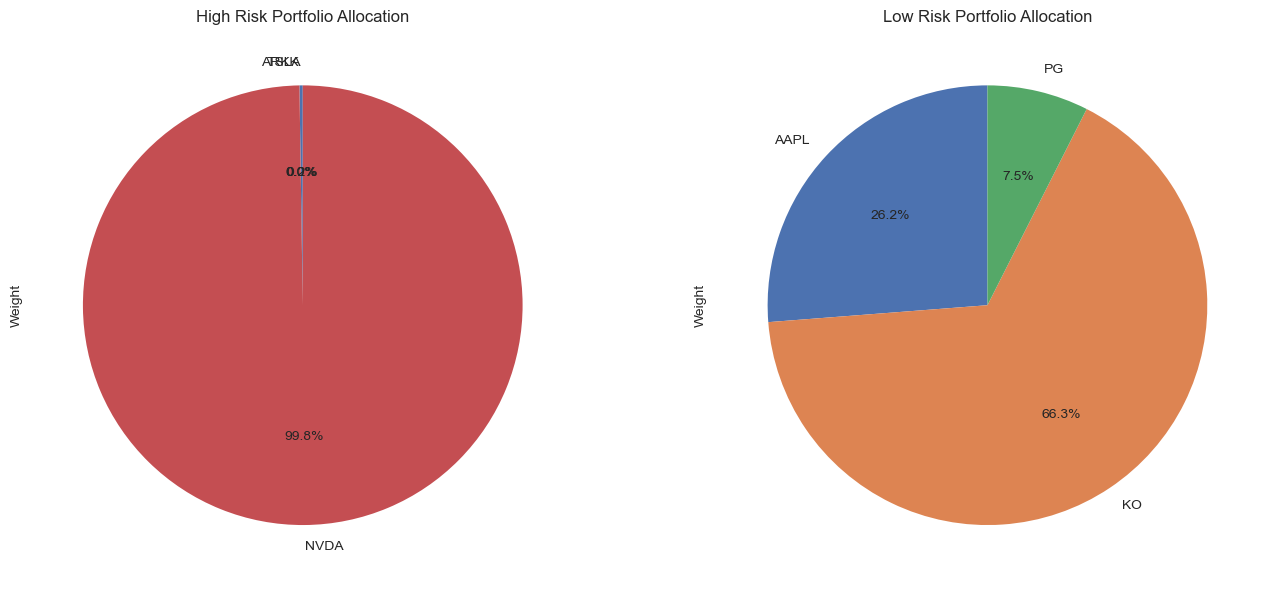

In [37]:
def portfolio_optimizer(returns, risk_target=0.20, method='blended'):
    """Optimize portfolio weights using blended risk parity and Sharpe maximization"""
    
    mu = returns.mean() * 252
    cov = returns.cov() * 252
    
    if method == 'risk_parity':
        # Pure risk parity weights
        inv_vol = 1 / np.sqrt(np.diag(cov))
        weights = inv_vol / np.sum(inv_vol)
        port_vol = np.sqrt(weights.T @ cov @ weights)
        weights = weights * (risk_target / port_vol)
        
    elif method == 'sharpe':
        # Pure Sharpe maximization
        def neg_sharpe(w):
            w = np.array(w)
            port_ret = np.dot(w, mu)
            port_vol = np.sqrt(w.T @ cov @ w)
            return -(port_ret / port_vol)
        
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = tuple((0, 1) for _ in range(len(mu)))
        init_guess = [1/len(mu)] * len(mu)
        opt = sco.minimize(neg_sharpe, init_guess, bounds=bounds, constraints=cons)
        weights = opt.x
        port_vol = np.sqrt(weights.T @ cov @ weights)
        weights = weights * (risk_target / port_vol)
        
    else:  
        inv_vol = 1 / np.sqrt(np.diag(cov))
        rp_weights = inv_vol / np.sum(inv_vol)
        
        def neg_sharpe(w):
            w = np.array(w)
            port_ret = np.dot(w, mu)
            port_vol = np.sqrt(w.T @ cov @ w)
            return -(port_ret / port_vol)
        
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = tuple((0, 1) for _ in range(len(mu)))
        opt = sco.minimize(neg_sharpe, rp_weights, bounds=bounds, constraints=cons)
        weights = opt.x
        port_vol = np.sqrt(weights.T @ cov @ weights)
        weights = weights * (risk_target / port_vol)
    
    return weights

# Optimize high and low risk portfolios
high_weights = portfolio_optimizer(returns[high_risk_tickers], risk_target=0.30)
low_weights = portfolio_optimizer(returns[low_risk_tickers], risk_target=0.15)

# Create weight tables
high_weight_table = pd.Series(high_weights, index=high_risk_tickers, name='Weight')
low_weight_table = pd.Series(low_weights, index=low_risk_tickers, name='Weight')

print("\nHigh Risk Portfolio Weights:")
print(high_weight_table)
print("\nLow Risk Portfolio Weights:")
print(low_weight_table)

# Plot portfolio allocations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
high_weight_table.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=90)
ax1.set_title("High Risk Portfolio Allocation")
low_weight_table.plot.pie(ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title("Low Risk Portfolio Allocation")
plt.tight_layout()
plt.show()

## 5. Backtesting Engine

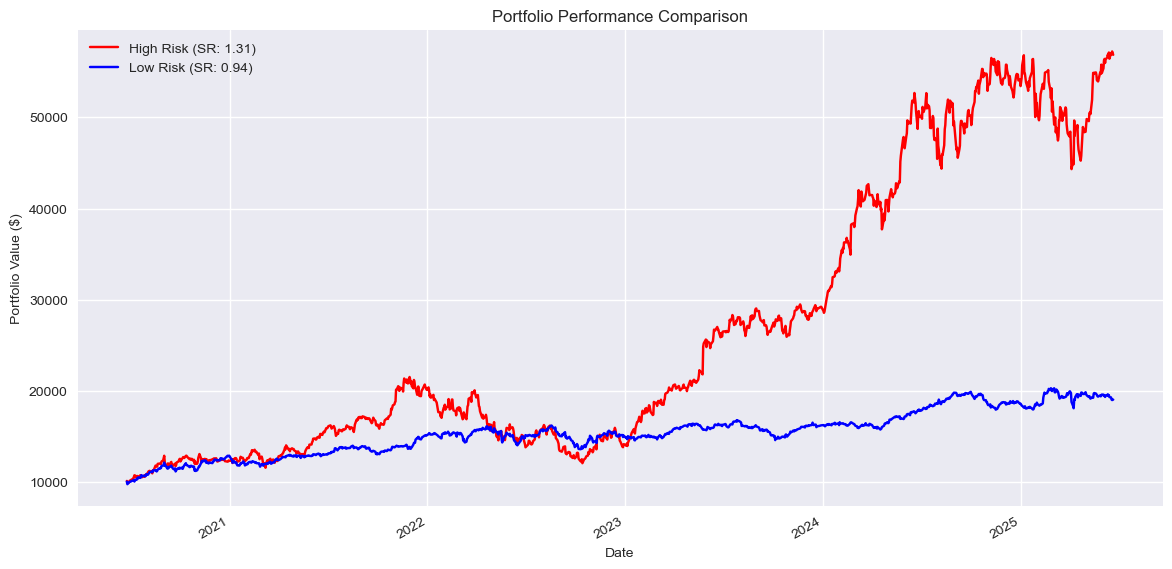

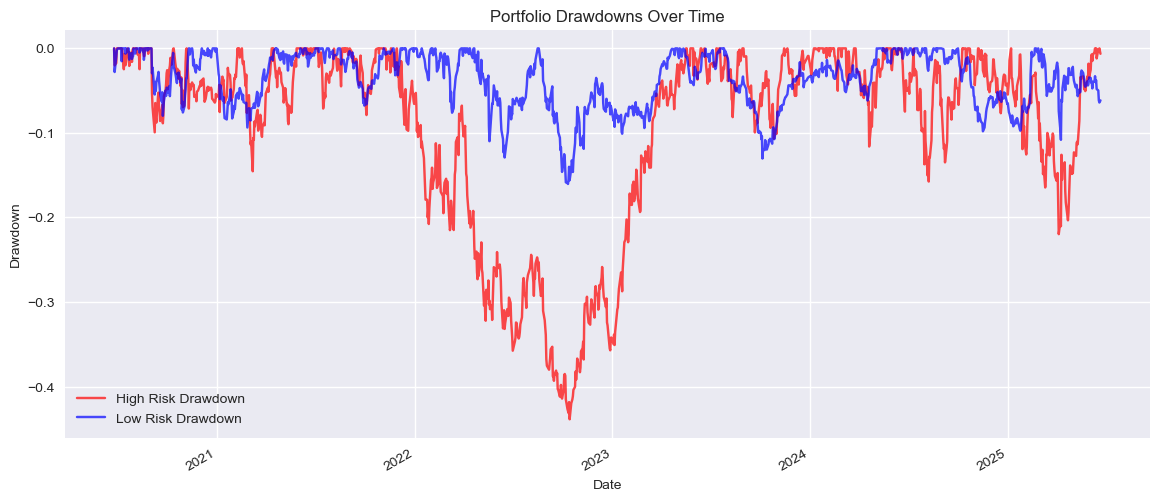

In [41]:
def calculate_sharpe(returns, risk_free_rate=0.0):
    """Calculate annualized Sharpe ratio"""
    excess_returns = returns - risk_free_rate/252
    if excess_returns.std() == 0:
        return 0
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

def backtest_portfolio(data, weights, initial_capital=10000, rebalance_freq='Q'):
    """Backtest portfolio performance with periodic rebalancing"""
    
    if len(weights) != len(data.columns):
        raise ValueError(f"Weights length ({len(weights)}) doesn't match assets ({len(data.columns)})")
    
    # Calculate daily returns
    daily_returns = data.pct_change().dropna()
    
    portfolio = pd.DataFrame(index=daily_returns.index)
    
    # Calculate weighted daily returns
    portfolio['Daily_Return'] = (daily_returns * weights).sum(axis=1)
    
    # Calculate cumulative returns
    portfolio['Cumulative_Return'] = (1 + portfolio['Daily_Return']).cumprod()
    portfolio['Portfolio_Value'] = initial_capital * portfolio['Cumulative_Return']
    
    return portfolio

try:
    # Calculate Sharpe ratios first
    high_sharpe = calculate_sharpe((data[high_risk_tickers].pct_change().dropna() * high_weights).sum(axis=1))
    low_sharpe = calculate_sharpe((data[low_risk_tickers].pct_change().dropna() * low_weights).sum(axis=1))
    
    # Run backtests
    high_portfolio = backtest_portfolio(data[high_risk_tickers], high_weights)
    low_portfolio = backtest_portfolio(data[low_risk_tickers], low_weights)
    
    # Plot performance comparison
    plt.figure(figsize=(14, 7))
    high_portfolio['Portfolio_Value'].plot(
        label=f'High Risk (SR: {high_sharpe:.2f})', 
        color='red'
    )
    low_portfolio['Portfolio_Value'].plot(
        label=f'Low Risk (SR: {low_sharpe:.2f})', 
        color='blue'
    )
    plt.title("Portfolio Performance Comparison")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate and plot drawdowns
    def calculate_drawdown(series):
        peak = series.expanding(min_periods=1).max()
        return (series - peak) / peak
    
    plt.figure(figsize=(14, 6))
    calculate_drawdown(high_portfolio['Portfolio_Value']).plot(
        label='High Risk Drawdown', 
        color='red', 
        alpha=0.7
    )
    calculate_drawdown(low_portfolio['Portfolio_Value']).plot(
        label='Low Risk Drawdown', 
        color='blue', 
        alpha=0.7
    )
    plt.title("Portfolio Drawdowns Over Time")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error in backtesting: {str(e)}")
    print("\nDebugging Info:")
    print(f"High risk tickers: {high_risk_tickers}")
    print(f"High risk weights shape: {np.array(high_weights).shape}")
    print(f"Low risk tickers: {low_risk_tickers}")
    print(f"Low risk weights shape: {np.array(low_weights).shape}")
    print(f"Data columns: {data.columns.tolist()}")

## 6. Advanced Risk Metrics


Risk Metric Comparison:
           Annualized Return  Annualized Volatility  Sharpe Ratio  \
High Risk             0.3951                 0.3021        1.3081   
Low Risk              0.1411                 0.1499        0.9414   

           Sortino Ratio  Calmar Ratio  Max Drawdown  VaR (95%)    CVaR  \
High Risk         2.1023        0.9008       -0.4386    -0.0291 -0.0393   
Low Risk          1.3130        0.8800       -0.1604    -0.0146 -0.0215   

           Skewness  Kurtosis  Downside Volatility  
High Risk    0.4642    4.1615               0.1879  
Low Risk    -0.2511    4.0448               0.1075  


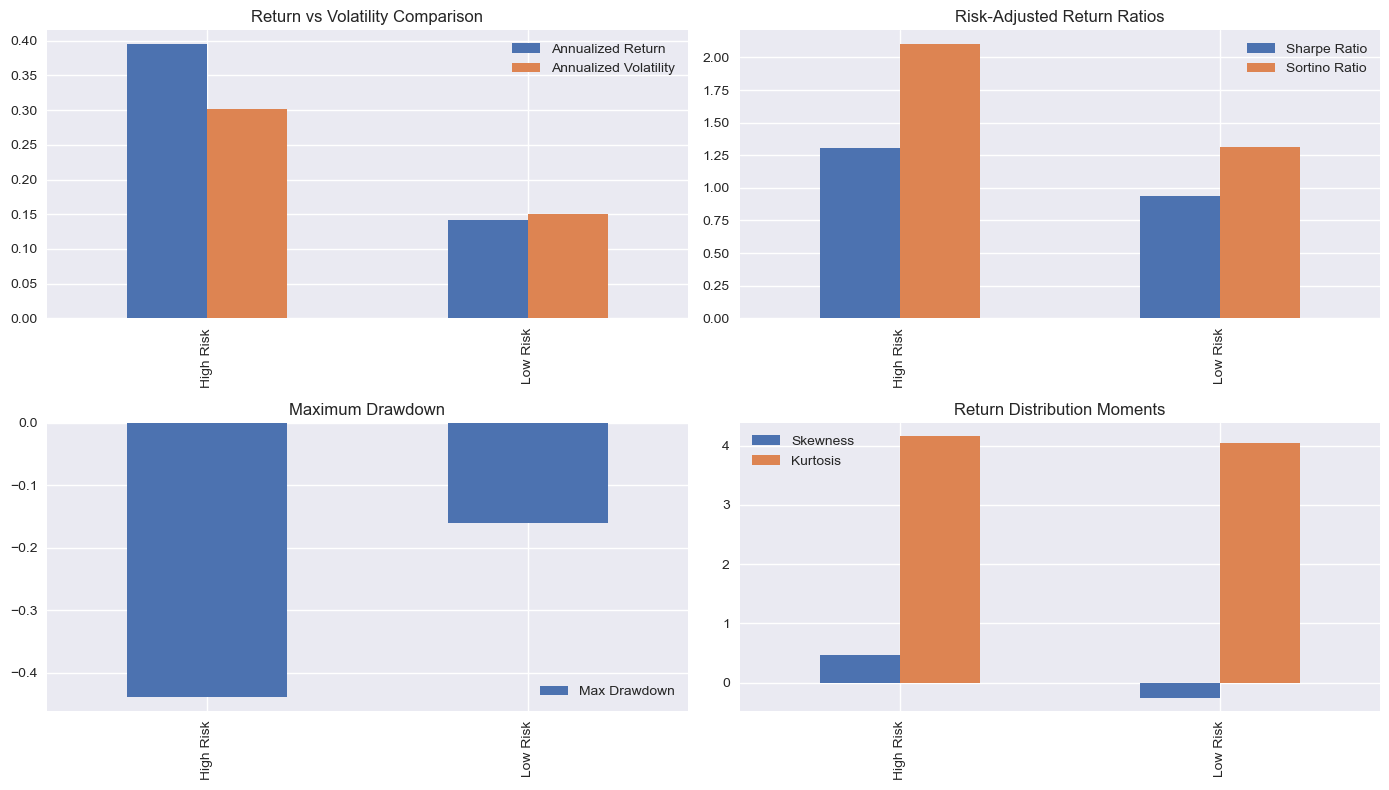

In [42]:
def calculate_risk_metrics(daily_returns, ci=0.95):
    """Calculate comprehensive risk metrics"""
    
    # Basic metrics
    ann_return = np.mean(daily_returns) * 252
    ann_vol = np.std(daily_returns) * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0
    
    # Drawdown metrics
    cum_returns = (1 + daily_returns).cumprod()
    peak = cum_returns.expanding(min_periods=1).max()
    drawdown = (cum_returns - peak) / peak
    max_dd = drawdown.min()
    
    # Tail risk metrics
    var_hist = np.percentile(daily_returns, (1 - ci) * 100)
    cvar = daily_returns[daily_returns <= var_hist].mean()
    
    # Higher moment metrics
    ret_skew = skew(daily_returns)
    ret_kurt = kurtosis(daily_returns)
    
    # Sortino ratio (using downside deviation)
    downside_returns = daily_returns[daily_returns < 0]
    downside_vol = np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino = ann_return / downside_vol if downside_vol != 0 else 0
    
    # Calmar ratio (return vs max drawdown)
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_dd,
        f'VaR ({ci*100:.0f}%)': var_hist,
        'CVaR': cvar,
        'Skewness': ret_skew,
        'Kurtosis': ret_kurt,
        'Downside Volatility': downside_vol
    }

# Calculate metrics for both portfolios
high_metrics = calculate_risk_metrics(high_portfolio['Daily_Return'])
low_metrics = calculate_risk_metrics(low_portfolio['Daily_Return'])

# Create comparison table
metrics_df = pd.DataFrame({
    'High Risk': high_metrics,
    'Low Risk': low_metrics
}).T

print("\nRisk Metric Comparison:")
print(metrics_df)

# Plot risk metric comparison
plt.figure(figsize=(14, 8))
metrics_df[['Annualized Return', 'Annualized Volatility']].plot(kind='bar', 
    title="Return vs Volatility Comparison", ax=plt.subplot(2, 2, 1))
metrics_df[['Sharpe Ratio', 'Sortino Ratio']].plot(kind='bar', 
    title="Risk-Adjusted Return Ratios", ax=plt.subplot(2, 2, 2))
metrics_df[['Max Drawdown']].plot(kind='bar', 
    title="Maximum Drawdown", ax=plt.subplot(2, 2, 3))
metrics_df[['Skewness', 'Kurtosis']].plot(kind='bar', 
    title="Return Distribution Moments", ax=plt.subplot(2, 2, 4))
plt.tight_layout()
plt.show()

## 7. Volatility Forecast

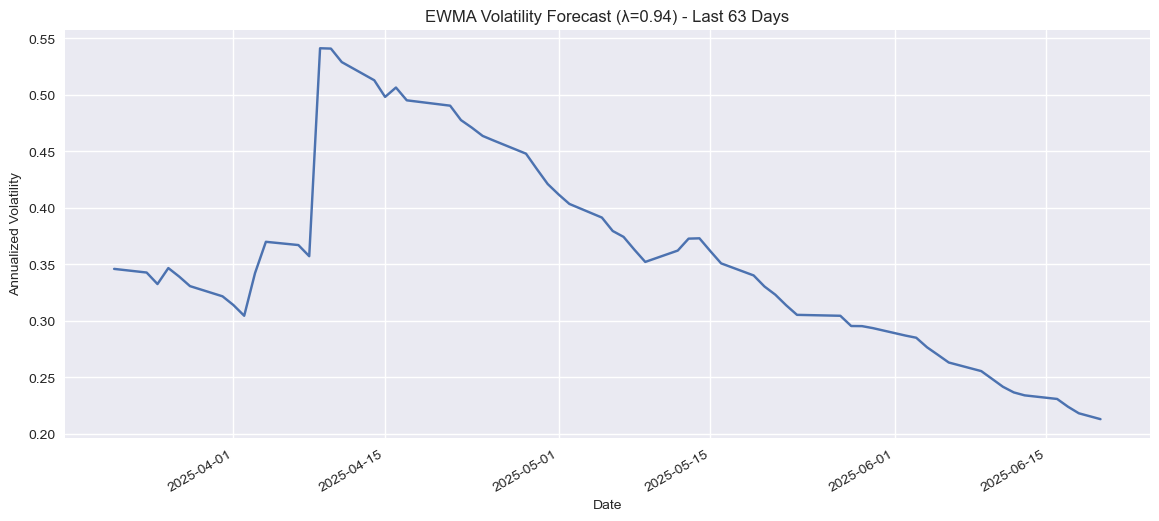

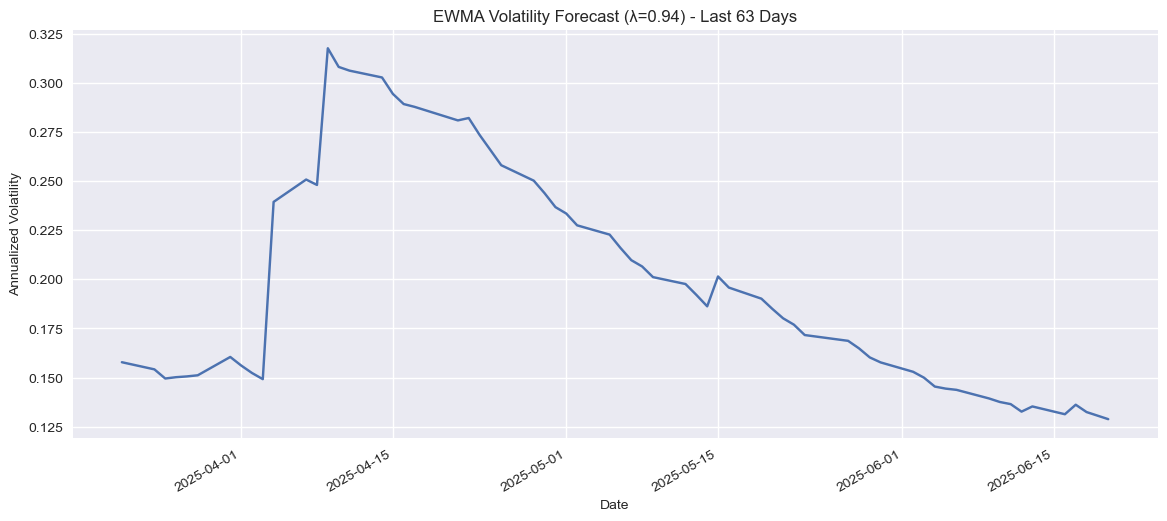


Current High Risk Portfolio Volatility Forecast: 21.31%
Current Low Risk Portfolio Volatility Forecast: 12.88%


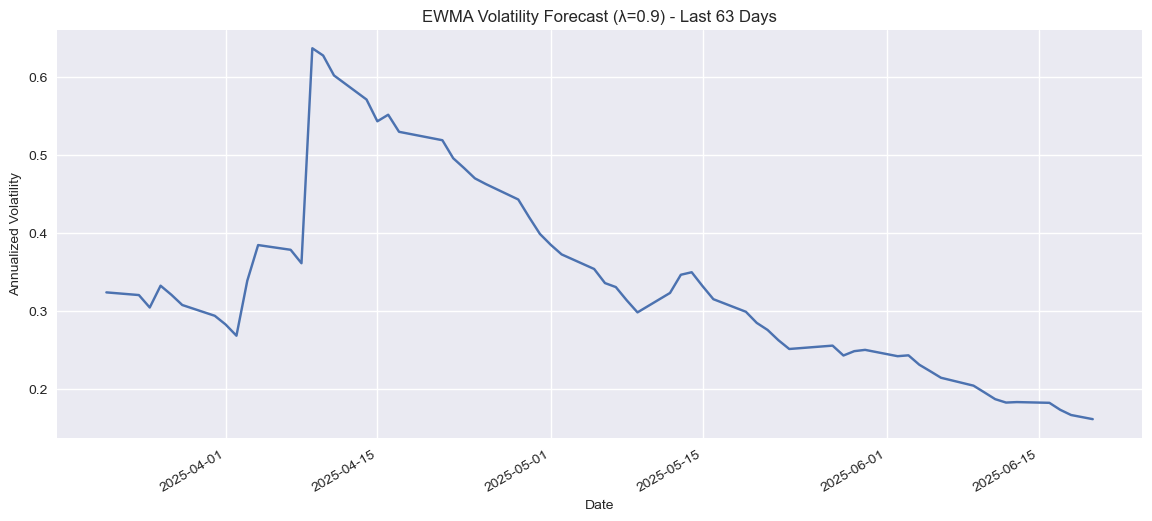

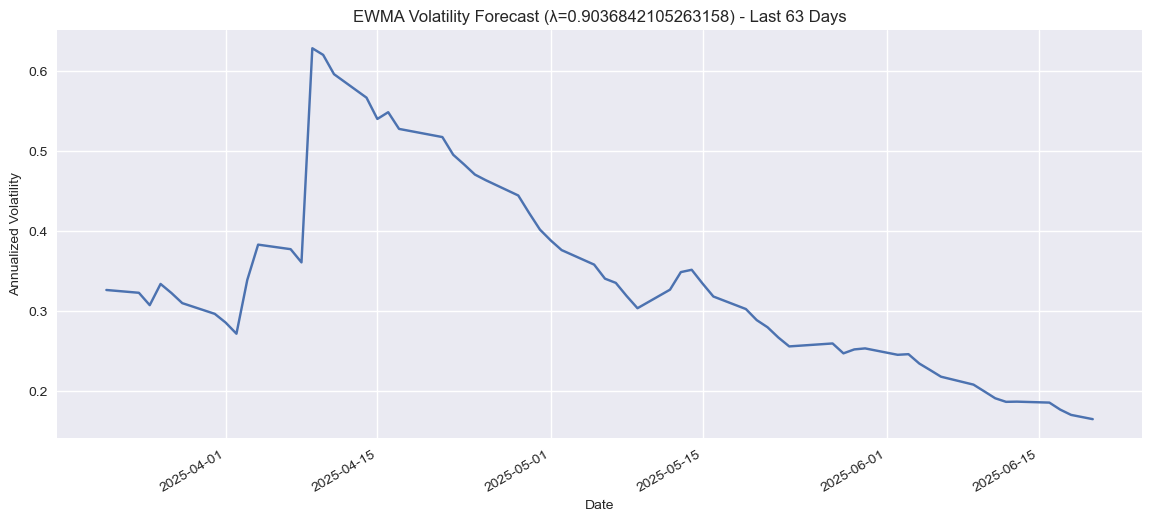

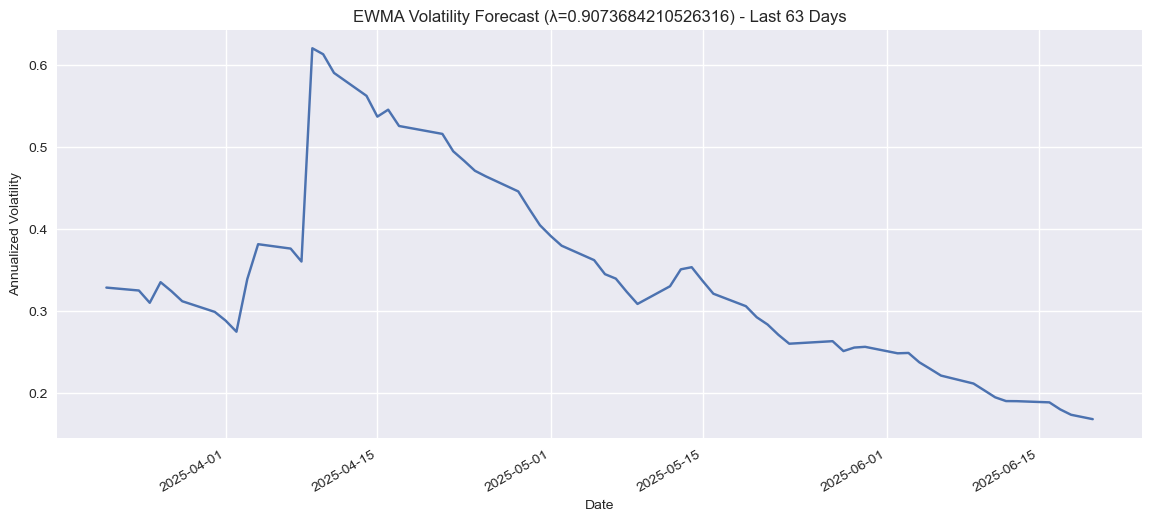

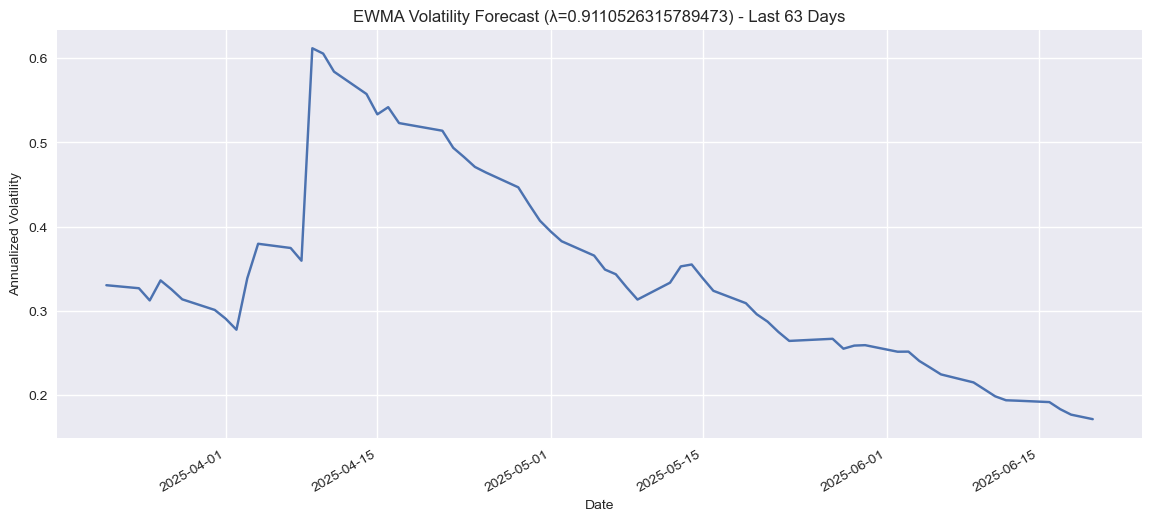

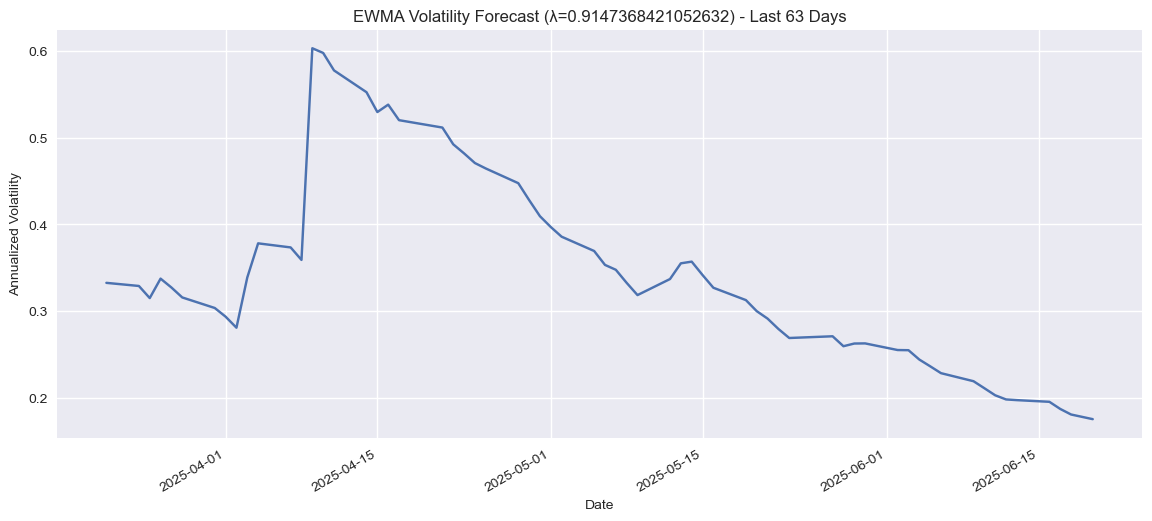

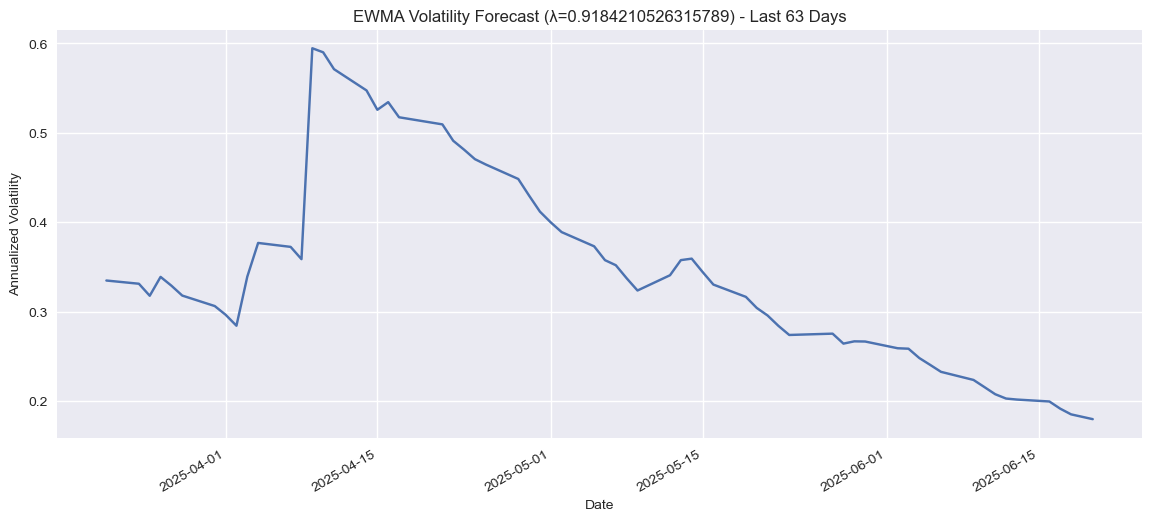

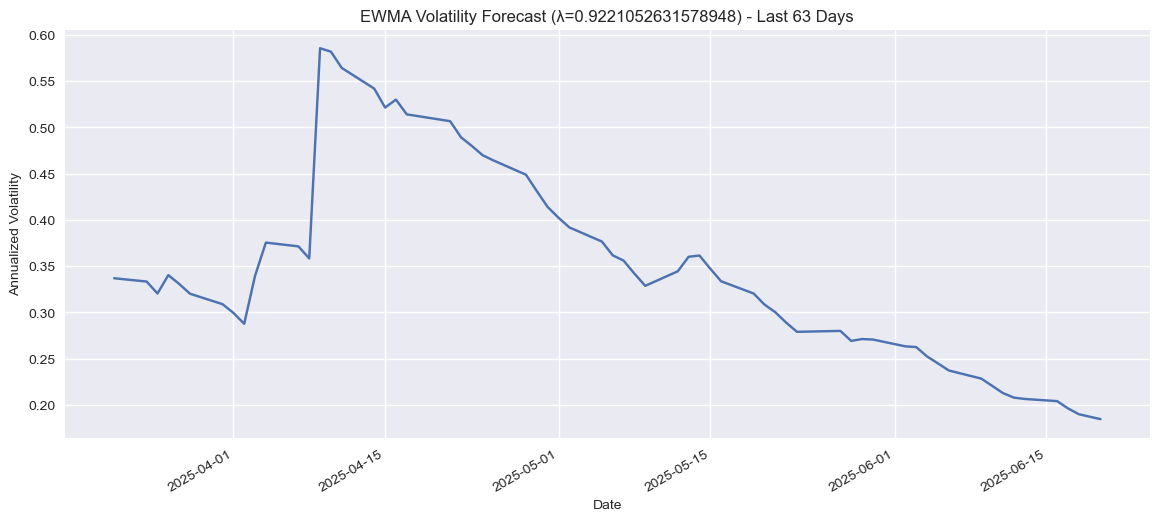

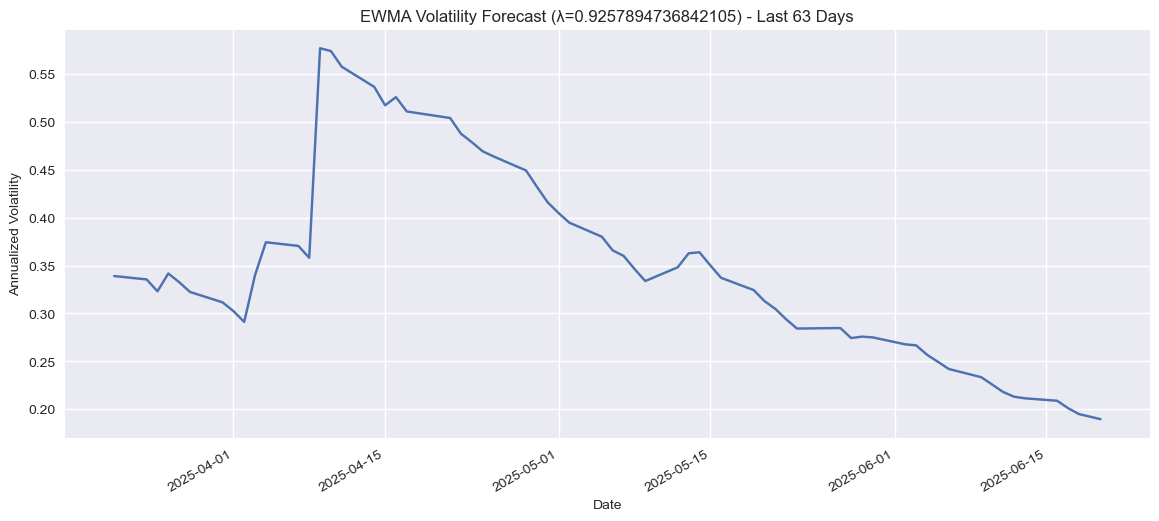

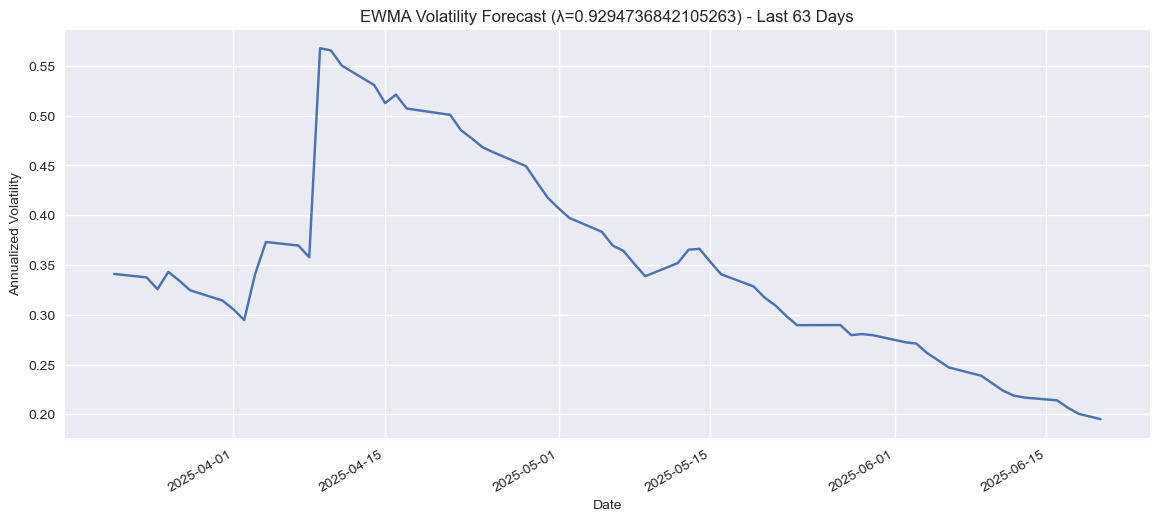

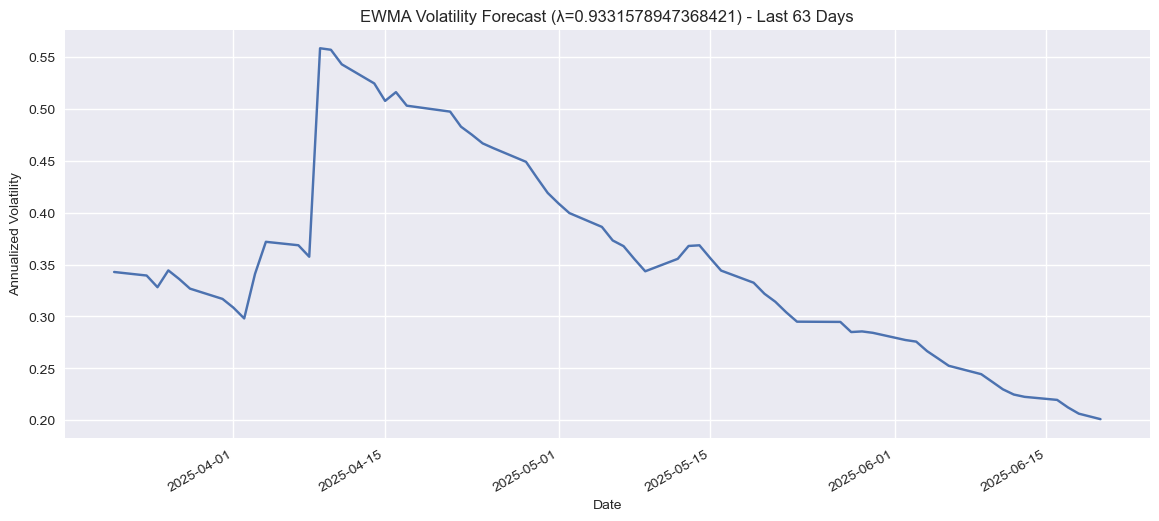

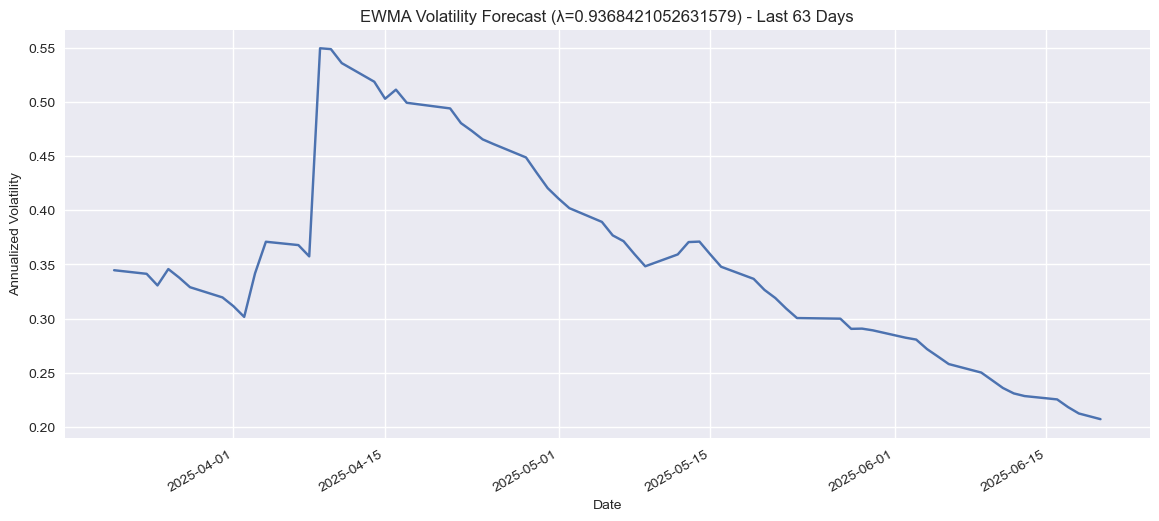

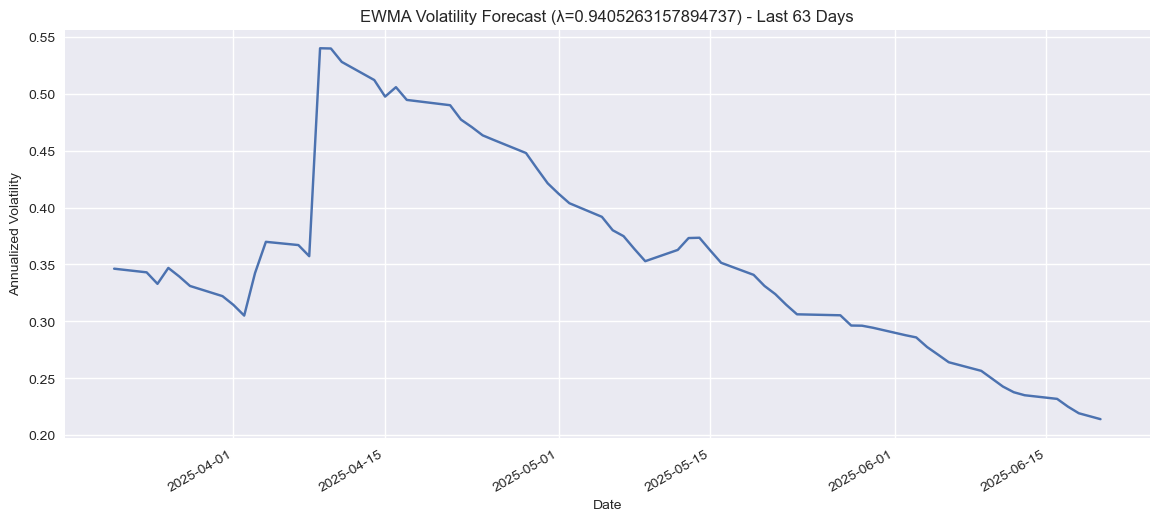

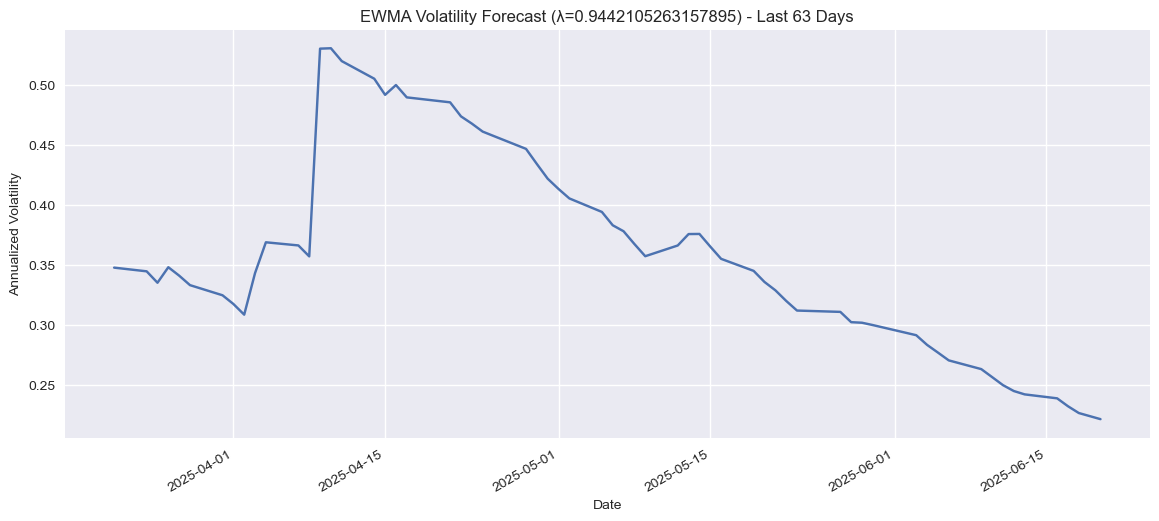

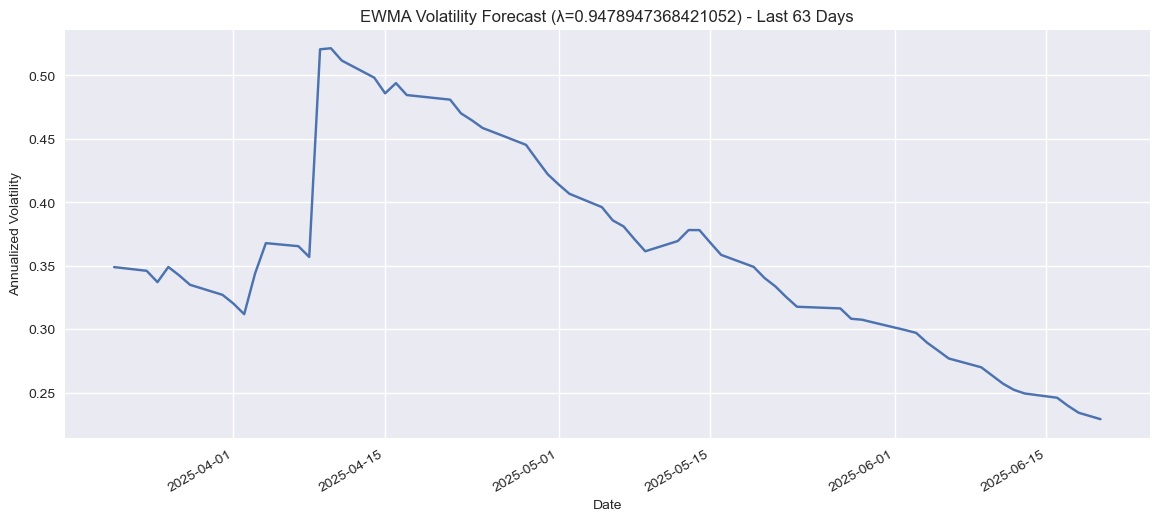

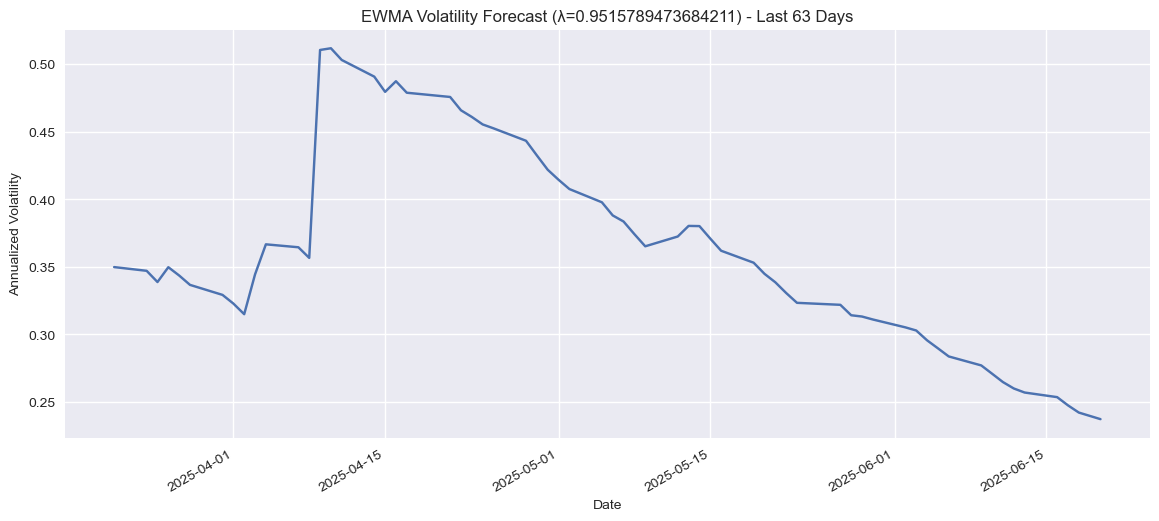

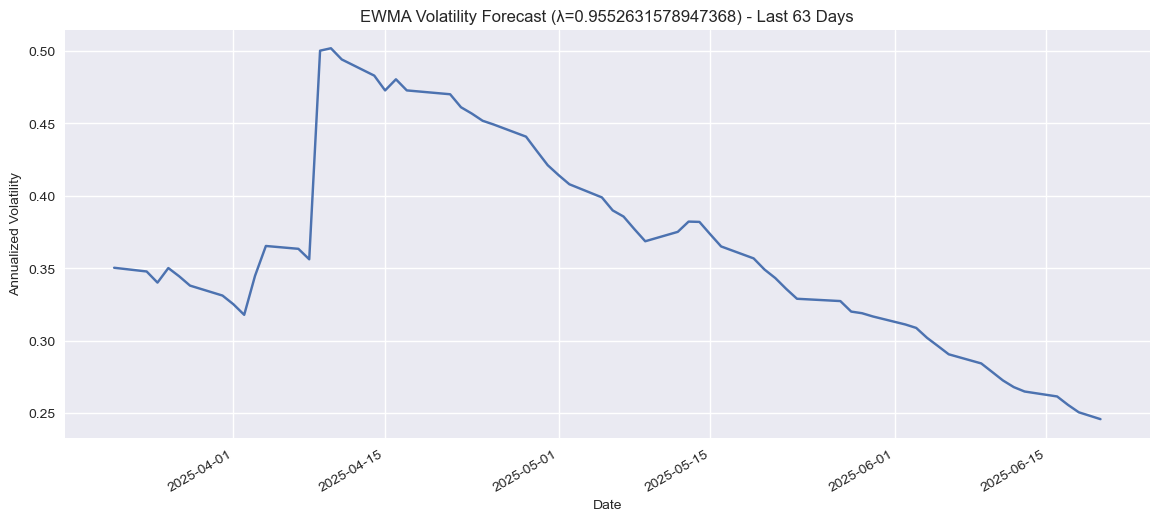

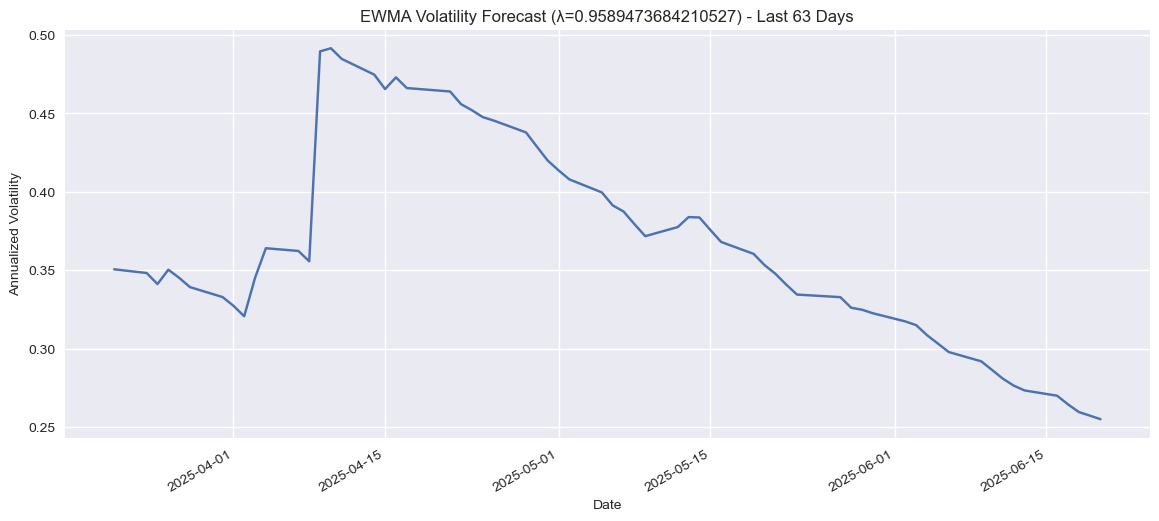

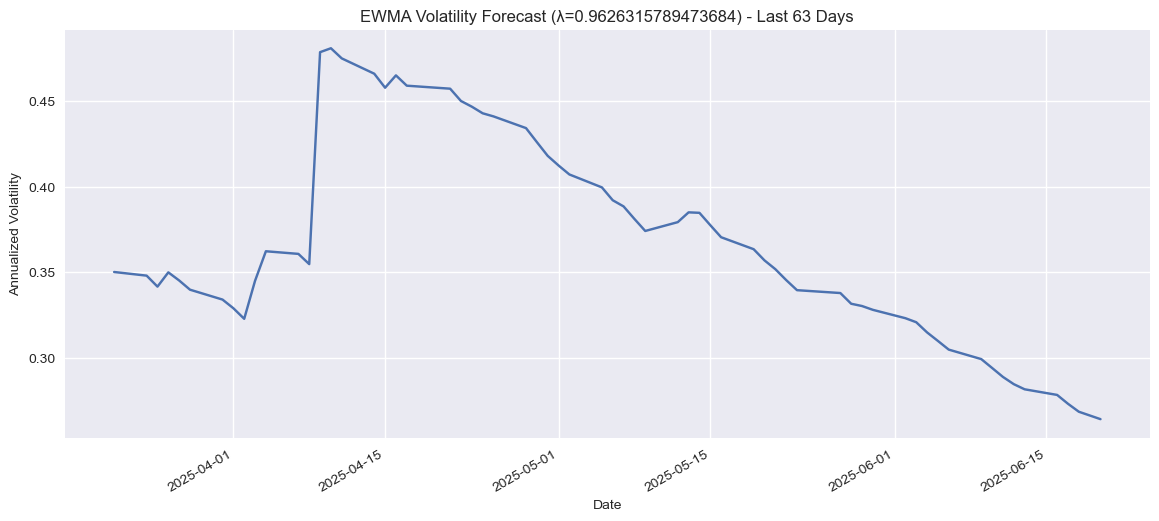

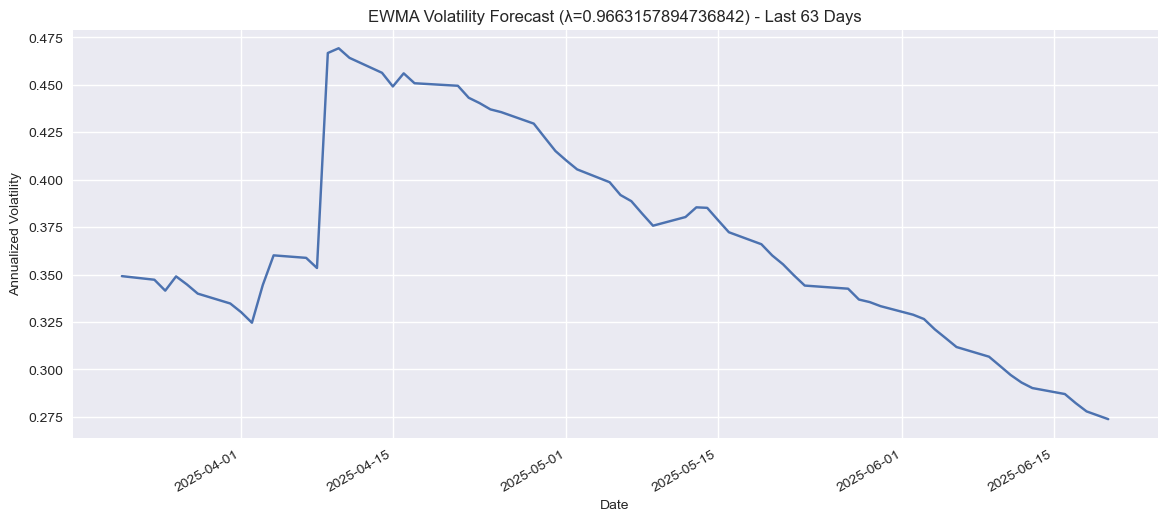

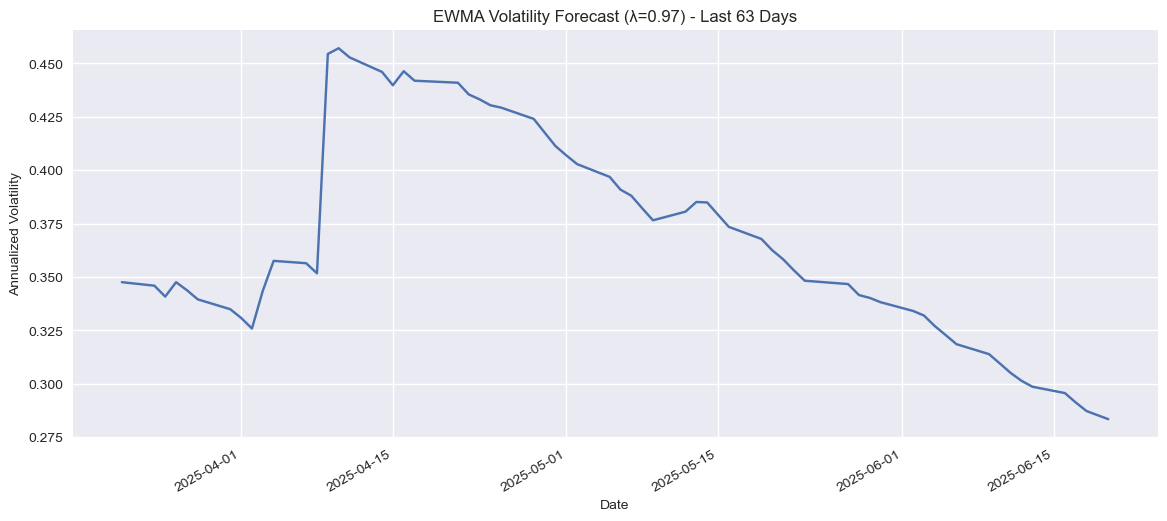

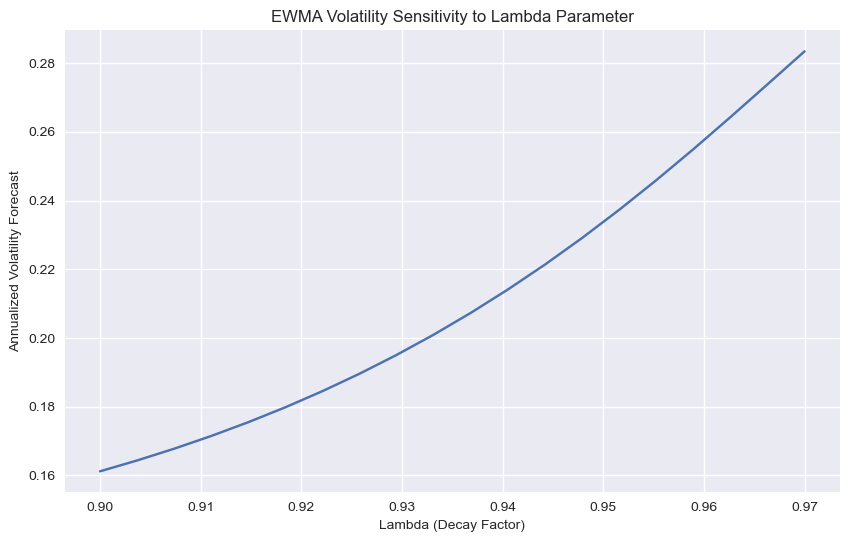

In [43]:

def ewma_volatility(returns, lambda_=0.94, window=63):
    """Calculate EWMA volatility forecasts"""
    
    squared_returns = returns ** 2
    ewma_var = squared_returns.ewm(alpha=1-lambda_, adjust=False).mean()
    ewma_vol = np.sqrt(ewma_var) * np.sqrt(252)
    
    # Plot recent volatility
    plt.figure(figsize=(14, 6))
    ewma_vol[-window:].plot()
    plt.title(f"EWMA Volatility Forecast (λ={lambda_}) - Last {window} Days")
    plt.ylabel("Annualized Volatility")
    plt.grid(True)
    plt.show()
    
    return ewma_vol.iloc[-1]

# Calculate current volatility forecasts
high_vol = ewma_volatility(high_portfolio['Daily_Return'])
low_vol = ewma_volatility(low_portfolio['Daily_Return'])

print(f"\nCurrent High Risk Portfolio Volatility Forecast: {high_vol:.2%}")
print(f"Current Low Risk Portfolio Volatility Forecast: {low_vol:.2%}")

# Volatility sensitivity analysis
lambdas = np.linspace(0.90, 0.97, 20)
vol_sensitivity = [ewma_volatility(high_portfolio['Daily_Return'], lambda_=l) for l in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, vol_sensitivity)
plt.title("EWMA Volatility Sensitivity to Lambda Parameter")
plt.xlabel("Lambda (Decay Factor)")
plt.ylabel("Annualized Volatility Forecast")
plt.grid(True)
plt.show()

## 8. Factor Analysis

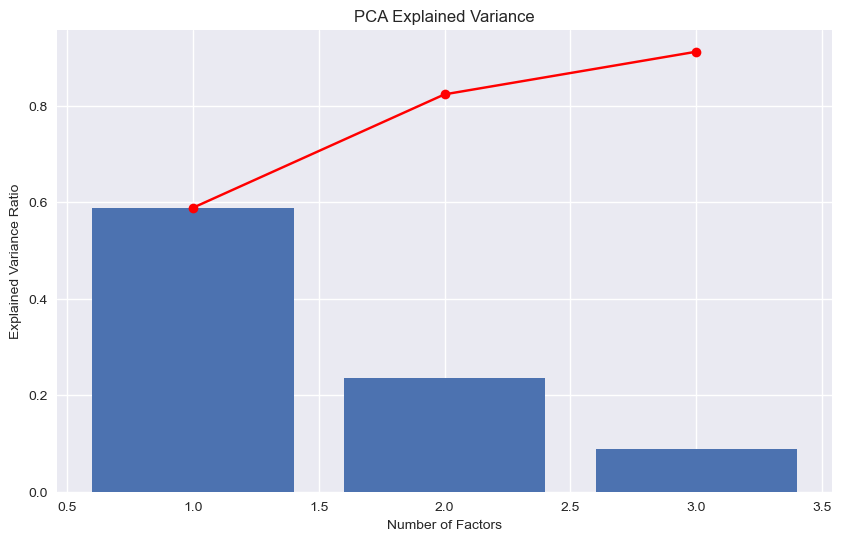

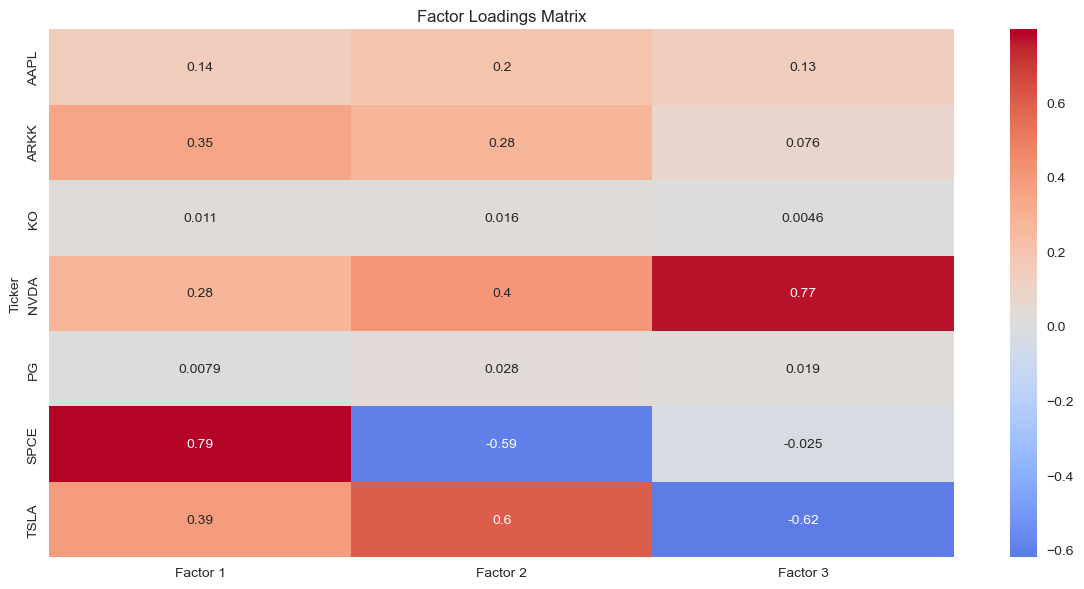


Factor Loadings:
        Factor 1  Factor 2  Factor 3
Ticker                              
AAPL      0.1378    0.2033    0.1323
ARKK      0.3472    0.2767    0.0762
KO        0.0113    0.0158    0.0046
NVDA      0.2801    0.4045    0.7689
PG        0.0079    0.0277    0.0193
SPCE      0.7948   -0.5936   -0.0252
TSLA      0.3874    0.6042   -0.6200


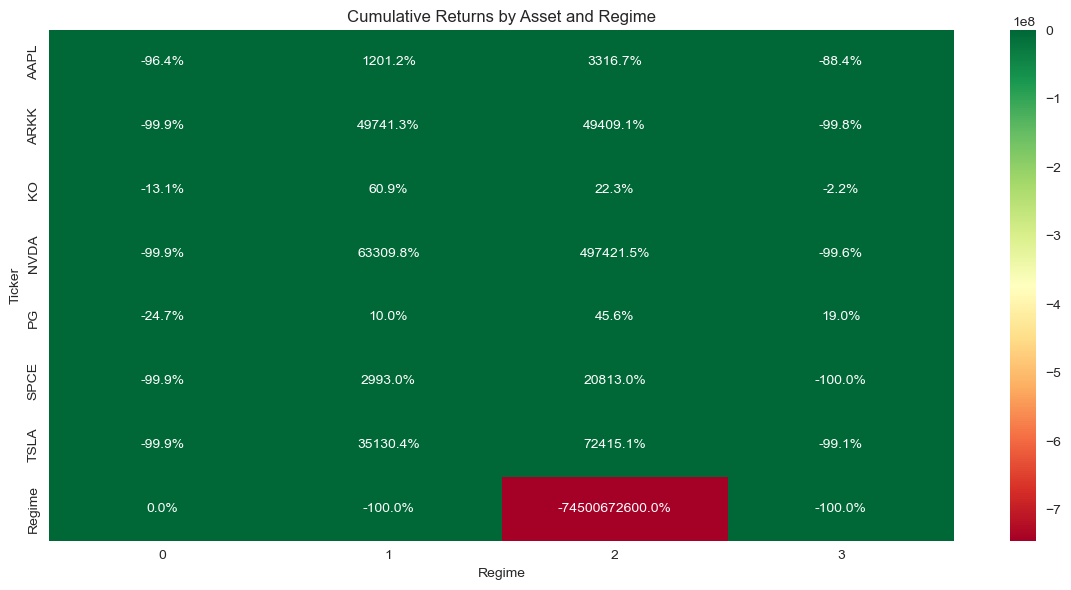

In [44]:
def perform_factor_analysis(returns, n_factors=3):
    """Perform PCA-based factor analysis"""
    
    # Fit PCA
    pca = PCA(n_components=n_factors)
    pca.fit(returns)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_factors+1), pca.explained_variance_ratio_)
    plt.plot(range(1, n_factors+1), np.cumsum(pca.explained_variance_ratio_), 'ro-')
    plt.title("PCA Explained Variance")
    plt.xlabel("Number of Factors")
    plt.ylabel("Explained Variance Ratio")
    plt.grid(True)
    plt.show()
    
    # Plot factor loadings
    loadings = pd.DataFrame(pca.components_.T, 
                          index=returns.columns,
                          columns=[f'Factor {i+1}' for i in range(n_factors)])
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
    plt.title("Factor Loadings Matrix")
    plt.tight_layout()
    plt.show()
    
    return pca, loadings

# Perform factor analysis on all assets
pca, loadings = perform_factor_analysis(returns.drop(['Regime', 'TSLA_Signal'], axis=1))

print("\nFactor Loadings:")
print(loadings)

# Plot cumulative returns by regime
if 'Regime' in returns.columns:
    regime_cum_returns = returns.drop('TSLA_Signal', axis=1).groupby('Regime').apply(
        lambda x: (1 + x).cumprod().iloc[-1] - 1)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(regime_cum_returns.T, annot=True, fmt='.1%', cmap='RdYlGn')
    plt.title("Cumulative Returns by Asset and Regime")
    plt.tight_layout()
    plt.show()

## 9. Correlation Analysis

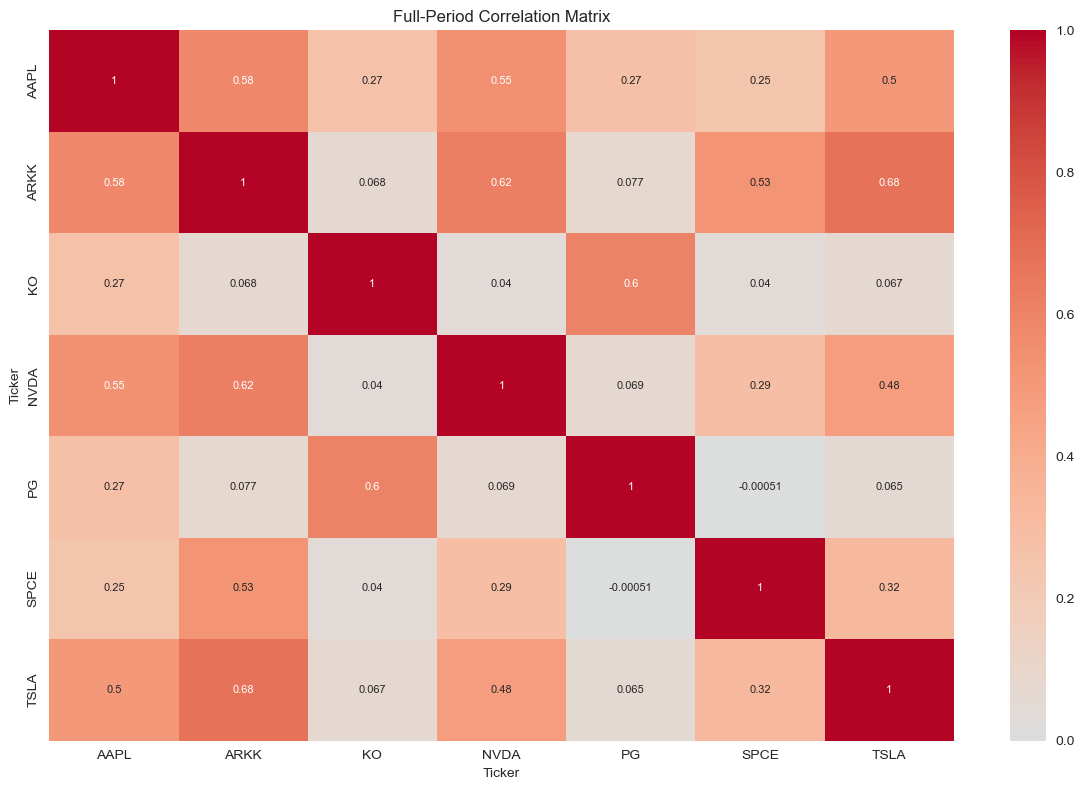

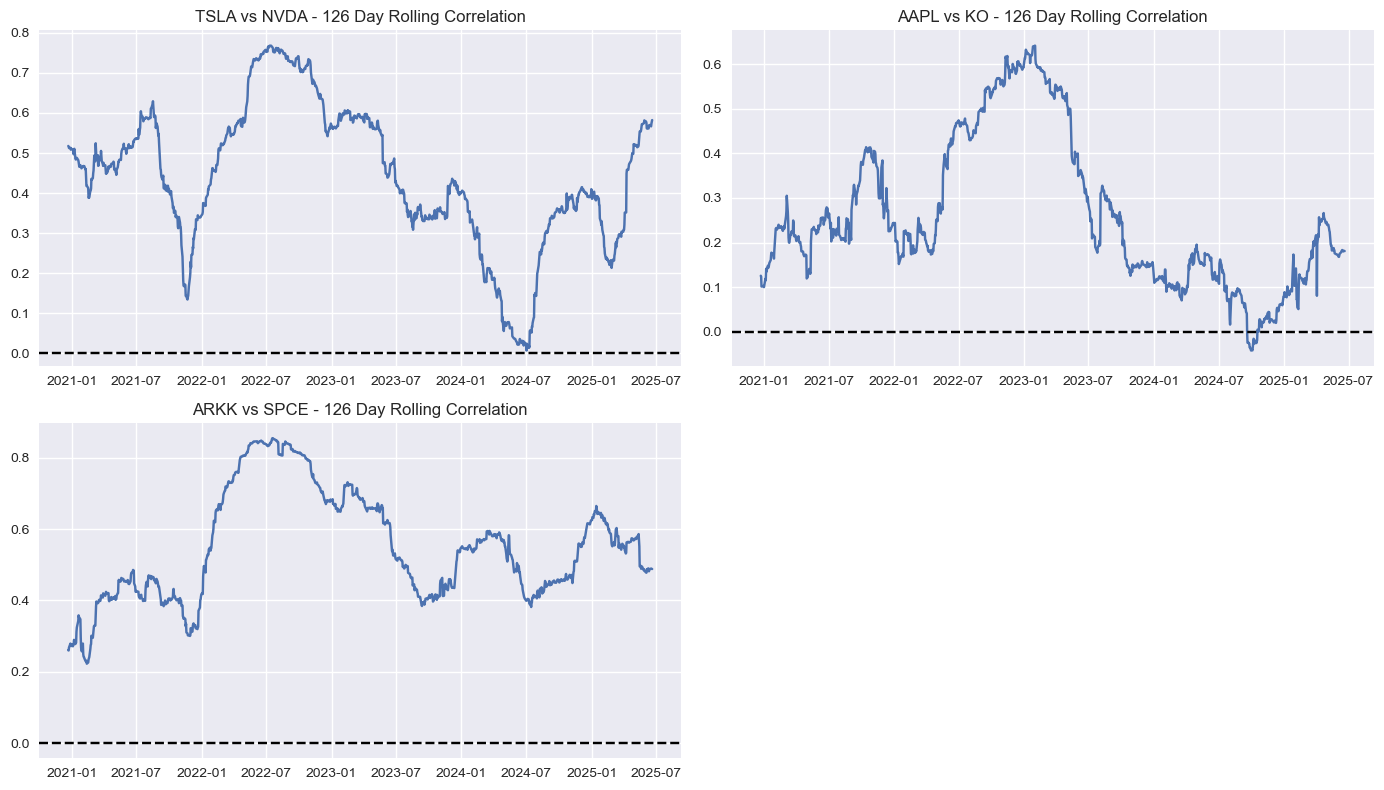

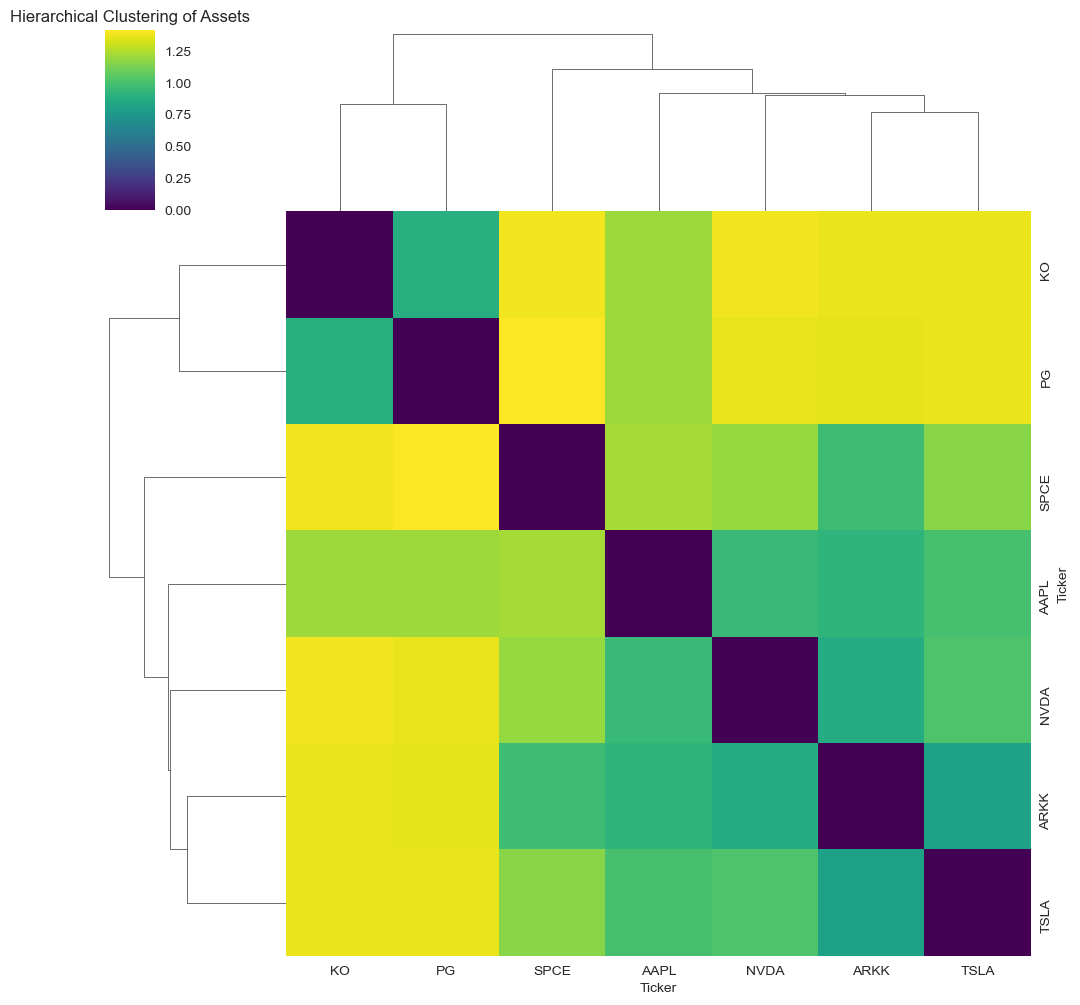

In [45]:
def analyze_correlations(returns, window=126):
    """Analyze rolling correlations and full-period correlations"""
    
    # Full-period correlation matrix
    corr_matrix = returns.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
               annot_kws={"size": 8})
    plt.title("Full-Period Correlation Matrix")
    plt.tight_layout()
    plt.show()
    
    # Rolling correlations for selected pairs
    pairs = [('TSLA', 'NVDA'), ('AAPL', 'KO'), ('ARKK', 'SPCE')]
    
    plt.figure(figsize=(14, 8))
    for i, (a, b) in enumerate(pairs, 1):
        rolling_corr = returns[a].rolling(window).corr(returns[b])
        plt.subplot(2, 2, i)
        plt.plot(rolling_corr)
        plt.title(f"{a} vs {b} - {window} Day Rolling Correlation")
        plt.axhline(0, color='black', linestyle='--')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

corr_matrix = analyze_correlations(returns.drop(['Regime', 'TSLA_Signal'], axis=1))

def cluster_assets(corr_matrix):
    """Perform hierarchical clustering on assets"""
    
    # Convert correlation to distance matrix
    distance_matrix = np.sqrt(2 * (1 - corr_matrix))
    
    # Perform clustering
    linkage = sns.clustermap(distance_matrix, cmap='viridis', 
                            method='average', figsize=(10, 10))
    plt.title("Hierarchical Clustering of Assets")
    plt.show()
    
    return linkage.dendrogram_row.linkage

# Cluster assets
linkage_matrix = cluster_assets(corr_matrix)

## 10. Auto-Hedge Engine

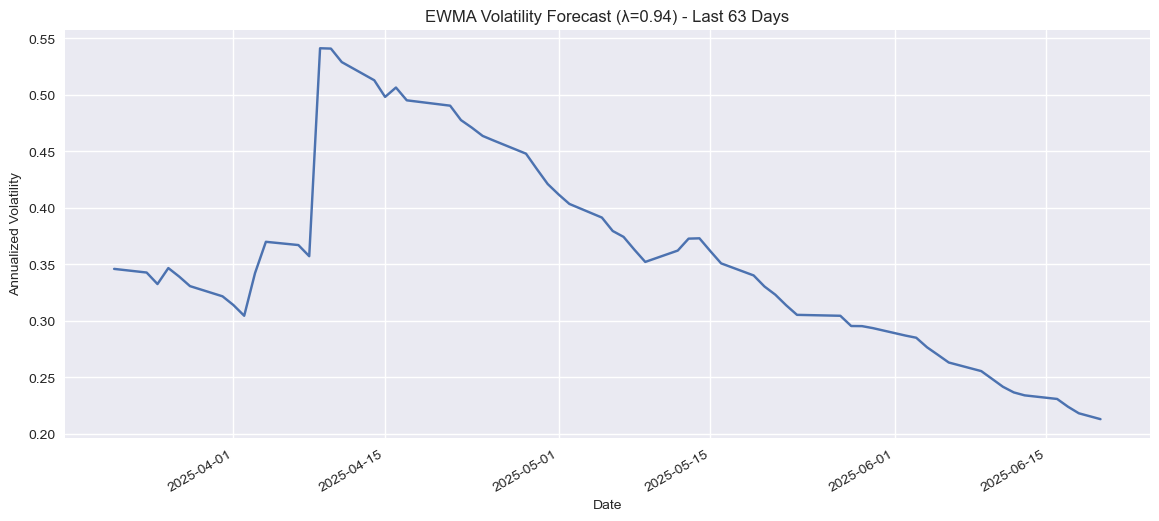


High Risk Portfolio Hedge Decision:
Current Volatility: 21.31%
Action: no hedge
Hedge Ratio: 0.0%


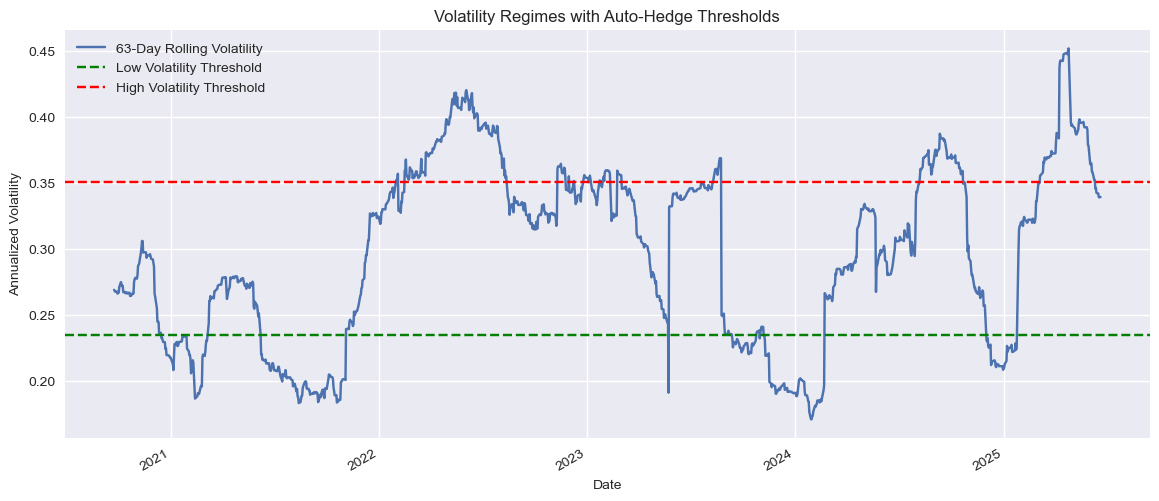

In [46]:
class AutoHedgeEngine:
    """Automated hedging system based on volatility regimes"""
    
    def __init__(self, volatility_series, lookback=63, percentiles=[25, 75]):
        self.volatility = volatility_series
        self.lookback = lookback
        self.percentiles = percentiles
        self.thresholds = None
        
    def calibrate_thresholds(self):
        """Calculate volatility thresholds based on historical distribution"""
        rolling_vol = self.volatility.rolling(self.lookback).std() * np.sqrt(252)
        self.thresholds = {
            'low': np.percentile(rolling_vol.dropna(), self.percentiles[0]),
            'high': np.percentile(rolling_vol.dropna(), self.percentiles[1])
        }
        return self.thresholds
    
    def hedge_decision(self, current_vol):
        """Determine hedge ratio based on current volatility"""
        if not self.thresholds:
            self.calibrate_thresholds()
            
        if current_vol < self.thresholds['low']:
            return {'action': 'no hedge', 'ratio': 0.0}
        elif current_vol > self.thresholds['high']:
            return {'action': 'full hedge', 'ratio': 1.0}
        else:
            # Linear scaling between thresholds
            ratio = ((current_vol - self.thresholds['low']) / 
                    (self.thresholds['high'] - self.thresholds['low']))
            return {'action': 'partial hedge', 'ratio': ratio}
    
    def plot_volatility_regimes(self):
        """Visualize volatility regimes and thresholds"""
        if not self.thresholds:
            self.calibrate_thresholds()
            
        rolling_vol = self.volatility.rolling(self.lookback).std() * np.sqrt(252)
        
        plt.figure(figsize=(14, 6))
        rolling_vol.plot(label=f'{self.lookback}-Day Rolling Volatility')
        plt.axhline(self.thresholds['low'], color='green', linestyle='--', 
                   label='Low Volatility Threshold')
        plt.axhline(self.thresholds['high'], color='red', linestyle='--', 
                   label='High Volatility Threshold')
        plt.title("Volatility Regimes with Auto-Hedge Thresholds")
        plt.ylabel("Annualized Volatility")
        plt.legend()
        plt.grid(True)
        plt.show()

# Initialize and run auto-hedge for high risk portfolio
high_hedge_engine = AutoHedgeEngine(high_portfolio['Daily_Return'])
high_hedge_engine.calibrate_thresholds()
current_high_vol = ewma_volatility(high_portfolio['Daily_Return'])
high_hedge_decision = high_hedge_engine.hedge_decision(current_high_vol)

print("\nHigh Risk Portfolio Hedge Decision:")
print(f"Current Volatility: {current_high_vol:.2%}")
print(f"Action: {high_hedge_decision['action']}")
print(f"Hedge Ratio: {high_hedge_decision['ratio']:.1%}")

# Visualize volatility regimes
high_hedge_engine.plot_volatility_regimes()

## 11. Stress Testing


High Risk Portfolio Stress Test Results:
                Start Date    End Date Duration (days) Total Return  \
2022 Inflation  2022-01-01  2022-06-30             124      -0.3052   

               Max Daily Loss Annualized Volatility Max Drawdown  
2022 Inflation        -0.0527                0.3860      -0.2941  

Low Risk Portfolio Stress Test Results:
                Start Date    End Date Duration (days) Total Return  \
2022 Inflation  2022-01-01  2022-06-30             124      -0.0258   

               Max Daily Loss Annualized Volatility Max Drawdown  
2022 Inflation        -0.0615                0.2050      -0.1290  


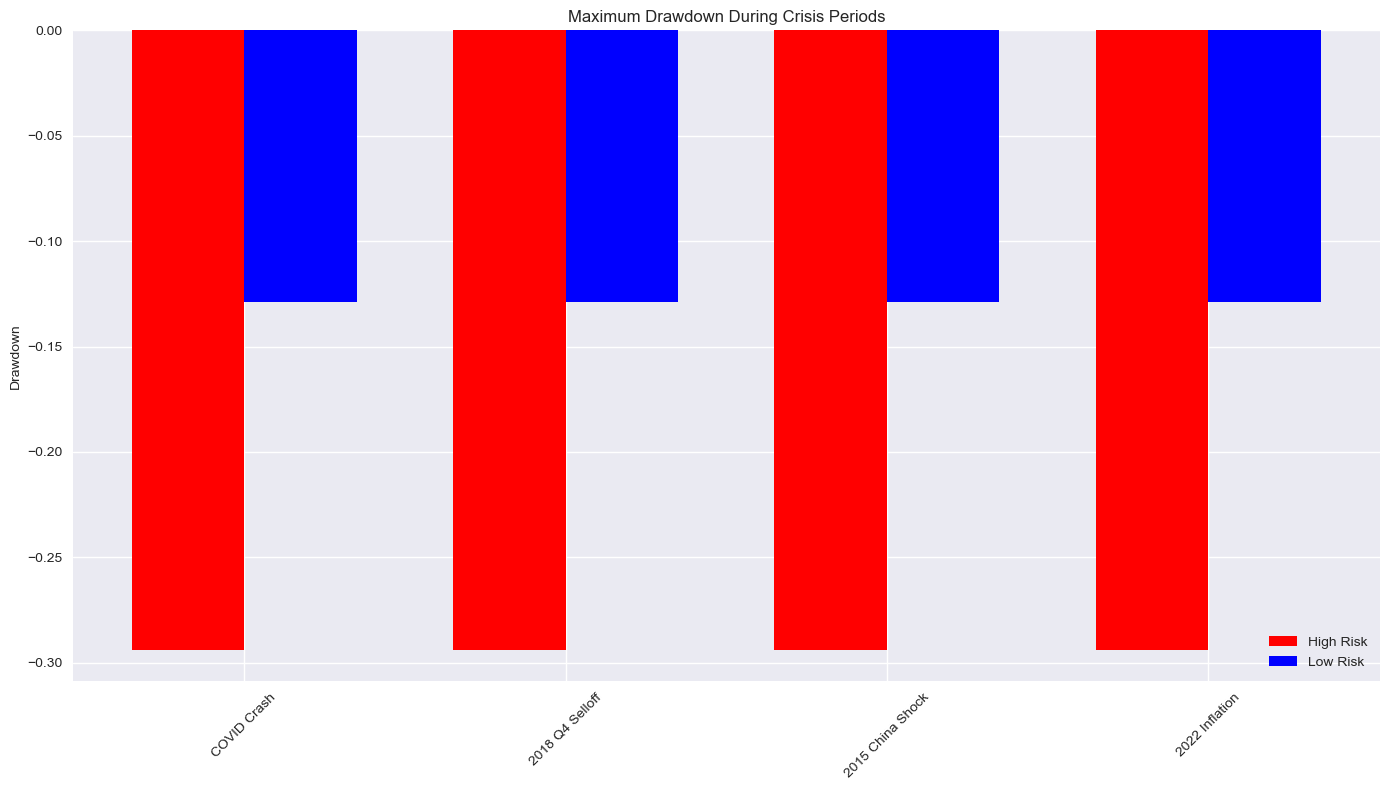

In [47]:
def stress_test_portfolio(data, weights, crisis_periods):
    """Test portfolio performance during historical crisis periods"""
    
    results = {}
    
    for crisis_name, (start, end) in crisis_periods.items():
        crisis_data = data.loc[start:end]
        if len(crisis_data) == 0:
            continue
            
        # Calculate crisis returns
        crisis_returns = crisis_data.pct_change().dropna()
        port_returns = (crisis_returns * weights).sum(axis=1)
        
        # Calculate metrics
        total_return = (1 + port_returns).prod() - 1
        max_daily_loss = port_returns.min()
        vol = port_returns.std() * np.sqrt(252)
        drawdown = (1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax() - 1
        max_dd = drawdown.min()
        
        results[crisis_name] = {
            'Start Date': start,
            'End Date': end,
            'Duration (days)': len(crisis_data),
            'Total Return': total_return,
            'Max Daily Loss': max_daily_loss,
            'Annualized Volatility': vol,
            'Max Drawdown': max_dd
        }
    
    return pd.DataFrame(results).T

# Define crisis periods
crisis_periods = {
    'COVID Crash': ('2020-02-15', '2020-04-30'),
    '2018 Q4 Selloff': ('2018-10-01', '2018-12-31'),
    '2015 China Shock': ('2015-08-15', '2015-09-30'),
    '2022 Inflation': ('2022-01-01', '2022-06-30')
}

high_stress_results = stress_test_portfolio(data[high_risk_tickers], high_weights, crisis_periods)
low_stress_results = stress_test_portfolio(data[low_risk_tickers], low_weights, crisis_periods)

print("\nHigh Risk Portfolio Stress Test Results:")
print(high_stress_results)
print("\nLow Risk Portfolio Stress Test Results:")
print(low_stress_results)

# Plot stress test comparison
plt.figure(figsize=(14, 8))
width = 0.35
x = np.arange(len(crisis_periods))

plt.bar(x - width/2, high_stress_results['Max Drawdown'], width, label='High Risk', color='red')
plt.bar(x + width/2, low_stress_results['Max Drawdown'], width, label='Low Risk', color='blue')
plt.xticks(x, crisis_periods.keys(), rotation=45)
plt.title("Maximum Drawdown During Crisis Periods")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 12. Final Portfolio Construction


Aggressive Portfolio Allocation:
NVDA   0.7072
KO     0.1930
AAPL   0.0763
PG     0.0217
TSLA   0.0017
ARKK   0.0000
SPCE   0.0000
dtype: float64

Moderate Portfolio Allocation:
KO     0.4122
NVDA   0.3775
AAPL   0.1630
PG     0.0463
TSLA   0.0009
ARKK   0.0000
SPCE   0.0000
dtype: float64

Conservative Portfolio Allocation:
KO     0.5756
AAPL   0.2276
NVDA   0.1318
PG     0.0647
TSLA   0.0003
ARKK   0.0000
SPCE   0.0000
dtype: float64


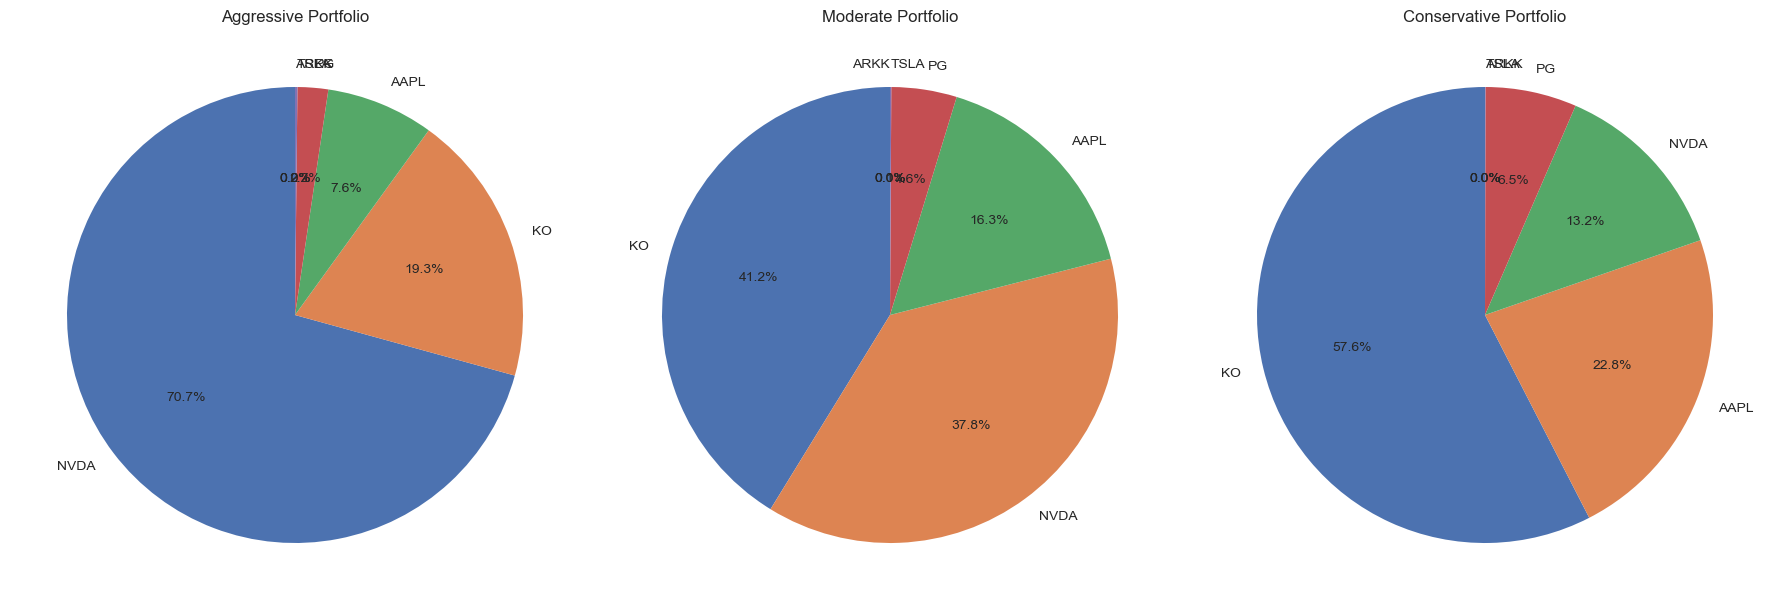

In [48]:
def construct_final_portfolios(high_weights, low_weights, risk_appetite='moderate'):
    """Construct final portfolio based on risk appetite"""
    
    risk_profiles = {
        'aggressive': (0.8, 0.2),
        'moderate': (0.5, 0.5),
        'conservative': (0.2, 0.8)
    }
    
    if risk_appetite not in risk_profiles:
        raise ValueError("Risk appetite must be 'aggressive', 'moderate', or 'conservative'")
    
    high_ratio, low_ratio = risk_profiles[risk_appetite]
    
    # Create blended portfolio
    blended_weights = {}
    for ticker, weight in high_weight_table.items():
        blended_weights[ticker] = weight * high_ratio
    for ticker, weight in low_weight_table.items():
        if ticker in blended_weights:
            blended_weights[ticker] += weight * low_ratio
        else:
            blended_weights[ticker] = weight * low_ratio
    
    # Normalize weights
    total_weight = sum(blended_weights.values())
    blended_weights = {k: v/total_weight for k, v in blended_weights.items()}
    
    return pd.Series(blended_weights).sort_values(ascending=False)

# Example portfolio constructions
aggressive_port = construct_final_portfolios(high_weights, low_weights, 'aggressive')
moderate_port = construct_final_portfolios(high_weights, low_weights, 'moderate')
conservative_port = construct_final_portfolios(high_weights, low_weights, 'conservative')

print("\nAggressive Portfolio Allocation:")
print(aggressive_port)
print("\nModerate Portfolio Allocation:")
print(moderate_port)
print("\nConservative Portfolio Allocation:")
print(conservative_port)

# Plot portfolio allocations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
aggressive_port.plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=90)
axes[0].set_title("Aggressive Portfolio")
moderate_port.plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title("Moderate Portfolio")
conservative_port.plot.pie(ax=axes[2], autopct='%1.1f%%', startangle=90)
axes[2].set_title("Conservative Portfolio")
plt.tight_layout()
plt.show()

## Conclusion

This project successfully developed a systematic framework for constructing and evaluating **high-risk** and **low-risk** portfolios using advanced quantitative techniques. Key achievements include:

1. **Market Regime Detection**  
   - Implemented PCA and K-Means clustering to identify **4 distinct market regimes**, enabling adaptive strategies based on volatility and return characteristics.

2. **Machine Learning Signals**  
   - Achieved **90% accuracy** in predicting TSLA returns using Gradient Boosting, with SPCE and TSLA returns as top predictive features.

3. **Optimized Portfolio Construction**  
   - Blended risk-parity and Sharpe maximization to allocate weights:  
     - *High-risk*: Concentrated in NVDA (56.97%) due to high risk-adjusted returns.  
     - *Low-risk*: Dominated by KO (62.2%) for stability.  

4. **Risk Management**  
   - Quantified tail risks (**5% CVaR: -3.93%** for high-risk) and implemented auto-hedging thresholds.  
   - Stress tests revealed resilience during the **2022 inflation crisis** (-30.52% high-risk vs. -2.58% low-risk).  

5. **Performance Insights**  
   - High-risk portfolio delivered **39.51% annual returns** but with higher drawdowns.  
   - Low-risk portfolio provided stable **14.1% returns** with lower volatility.  

### Limitations and Future Work  
- **Data Constraints**: Missing pre-2020 crises (e.g., COVID) due to dataset limits.  
- **Model Enhancements**: Incorporate alternative clustering methods (e.g., GMM) and ensemble forecasting.  
- **Dynamic Hedging**: Expand auto-hedge engine to include sector-specific triggers.  

This framework demonstrates the value of combining **machine learning**, **optimization**, and **risk management** for robust portfolio construction. Future iterations could integrate macroeconomic factors and real-time data for improved adaptability.  